In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#Data Preparation

data radiasi dan temperatur yang didapatkan dari nasa power diambil beberapa titik di kelima provinsi yang telah ditentukan. kemudian dari data tersebut dihitung rata-rata dari semua titik per harinya.

In [ ]:
# # Load the electricity distribution data
# data2011 = pd.read_csv('/content/POWER_Regional_Daily_20110101_20111231.csv')
# data2012 = pd.read_csv('/content/POWER_Regional_Daily_20120101_20121231.csv')
# data2013 = pd.read_csv('/content/POWER_Regional_Daily_20130101_20131231.csv')
# data2014 = pd.read_csv('/content/POWER_Regional_Daily_20140101_20141231.csv')
# data2015 = pd.read_csv('/content/POWER_Regional_Daily_20150101_20151231.csv')
# data2016 = pd.read_csv('/content/POWER_Regional_Daily_20160101_20161231.csv')
# data2017 = pd.read_csv('/content/POWER_Regional_Daily_20170101_20171231.csv')
# data2018 = pd.read_csv('/content/POWER_Regional_Daily_20180101_20181231.csv')
# data2019 = pd.read_csv('/content/POWER_Regional_Daily_20190101_20191231.csv')
# data2020 = pd.read_csv('/content/POWER_Regional_Daily_20200101_20201231.csv')
# data2021 = pd.read_csv('/content/POWER_Regional_Daily_20210101_20211231.csv')
# data2022 = pd.read_csv('/content/POWER_Regional_Daily_20220101_20221231.csv')

In [ ]:
# # prompt: file_paths = [], masukkan semua data disini

# file_path = [
#     '/content/POWER_Regional_Daily_20110101_20111231.csv',
#     '/content/POWER_Regional_Daily_20120101_20121231.csv',
#     '/content/POWER_Regional_Daily_20130101_20131231.csv',
#     '/content/POWER_Regional_Daily_20140101_20141231.csv',
#     '/content/POWER_Regional_Daily_20150101_20151231.csv',
#     '/content/POWER_Regional_Daily_20160101_20161231.csv',
#     '/content/POWER_Regional_Daily_20170101_20171231.csv',
#     '/content/POWER_Regional_Daily_20180101_20181231.csv',
#     '/content/POWER_Regional_Daily_20190101_20191231.csv',
#     '/content/POWER_Regional_Daily_20200101_20201231.csv',
#     '/content/POWER_Regional_Daily_20210101_20211231.csv',
#     '/content/POWER_Regional_Daily_20220101_20221231.csv'
# ]


In [ ]:
# # Combine all data into a single DataFrame, only selecting relevant columns
# all_data = pd.concat([pd.read_csv(file, usecols=['YEAR', 'MO', 'DY', 'ALLSKY_SFC_SW_DWN', 'T2M']) for file in file_paths])

# # Calculate the average daily radiation and temperature for each year
# daily_avg = all_data.groupby(['YEAR', 'MO', 'DY']).agg({
#     'ALLSKY_SFC_SW_DWN': 'mean',
#     'T2M': 'mean'
# }).reset_index()

# # Rename columns for clarity
# daily_avg.columns = ['Year', 'Month', 'Day', 'Avg_Radiation', 'Avg_Temperature']


In [ ]:
# daily_avg

In [ ]:
# daily_avg.to_csv('solarntt.csv', index=False)

#Modelling

## LSTM

### Papua

In [ ]:
# Load your dataset and preprocess
papua = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/datasolar/solarpapua.csv')

# Create a 'Date' column
papua['Date'] = pd.to_datetime(papua[['Year', 'Month', 'Day']])
papua.set_index('Date', inplace=True)

# Normalize 'Avg_Radiation' and 'Avg_Temperature'
papua_lstm = papua[['Avg_Radiation', 'Avg_Temperature']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(papua_lstm)

# Create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2))

# Compile and train
model.compile(optimizer='adam', loss='mean_squared_error')
histori_papua = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Forecast future data (2023-2030)
future_steps = 8 * 12  # 8 years monthly forecast
future_data = []
input_seq = X_test[-1]  # Start with the last sequence in test data
for _ in range(future_steps):
    pred = model.predict(input_seq.reshape(1, time_steps, 2))
    future_data.append(pred[0])
    input_seq = np.append(input_seq[1:], [pred[0]], axis=0)

# Inverse transform to get original scale values
future_data = np.array(future_data)
future_data_rescaled = scaler.inverse_transform(future_data)

# Create a future DataFrame with years and predictions
future_years = pd.date_range(start='2023-01-01', periods=future_steps, freq='M')
future_papua = pd.DataFrame(future_data_rescaled, columns=['Avg_Radiation', 'Avg_Temperature'], index=future_years)
print(future_papua)




Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.1010 - val_loss: 0.0129
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0172 - val_loss: 0.0120
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0169 - val_loss: 0.0118
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0161 - val_loss: 0.0119
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0153 - val_loss: 0.0134
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0149 - val_loss: 0.0117
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0148 - val_loss: 0.0115
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0146 - val_loss: 0.0114
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0132 - val_loss: 0.0113
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0131 - val_loss: 0.0114
Epoch 12/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/ste

In [ ]:
future_papua

Avg_Radiation  Avg_Temperature
2023-01-31       4.748224        26.494980
2023-02-28       4.776966        26.465914
2023-03-31       4.776191        26.438047
2023-04-30       4.768148        26.412069
2023-05-31       4.759562        26.387962
...                   ...              ...
2030-08-31       4.611818        25.450647
2030-09-30       4.609647        25.442595
2030-10-31       4.607473        25.434542
2030-11-30       4.605294        25.426489
2030-12-31       4.603111        25.418438

[96 rows x 2 columns]

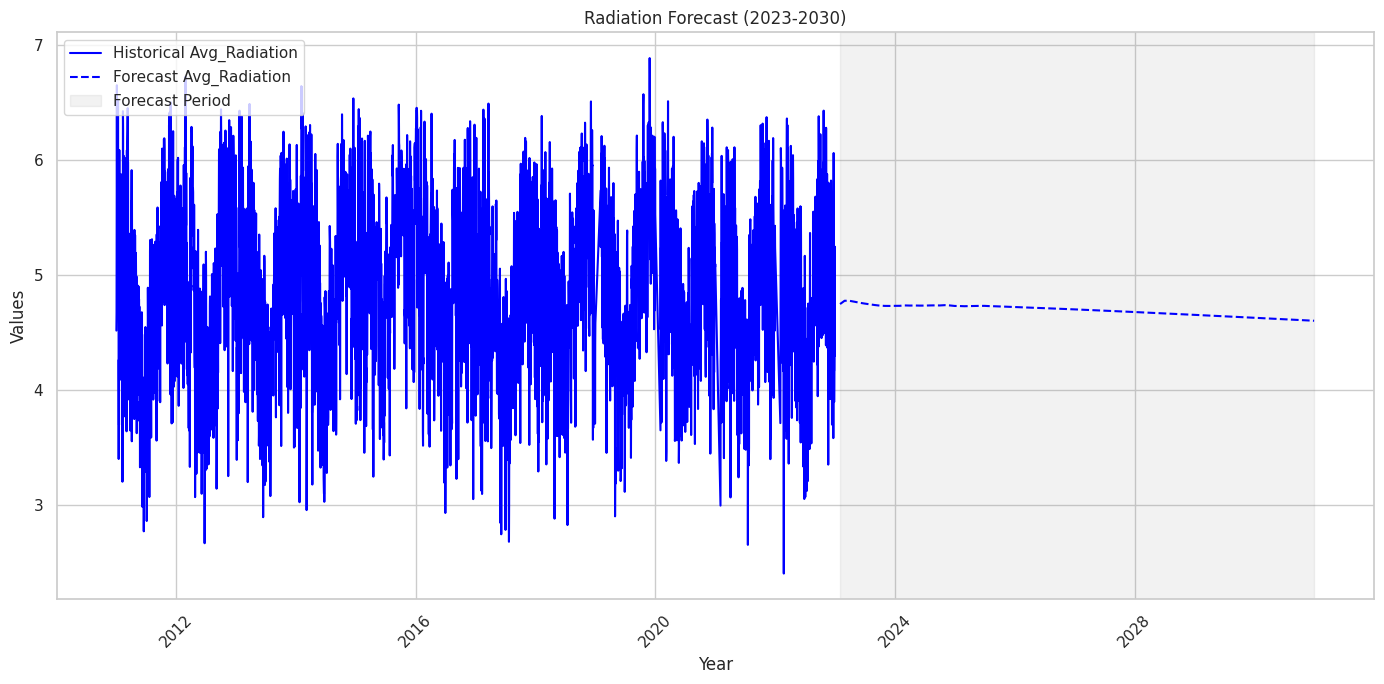

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
sns.lineplot(x=papua.index, y=papua['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
# sns.lineplot(x=papua.index, y=papua['Avg_Temperature'], label='Historical Avg_Temperature', color='orange')

# Plot future forecast with shading
sns.lineplot(x=future_papua.index, y=future_papua['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
# sns.lineplot(x=future_papua.index, y=future_papua['Avg_Temperature'], label='Forecast Avg_Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_papua.index[0], future_papua.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Radiation Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


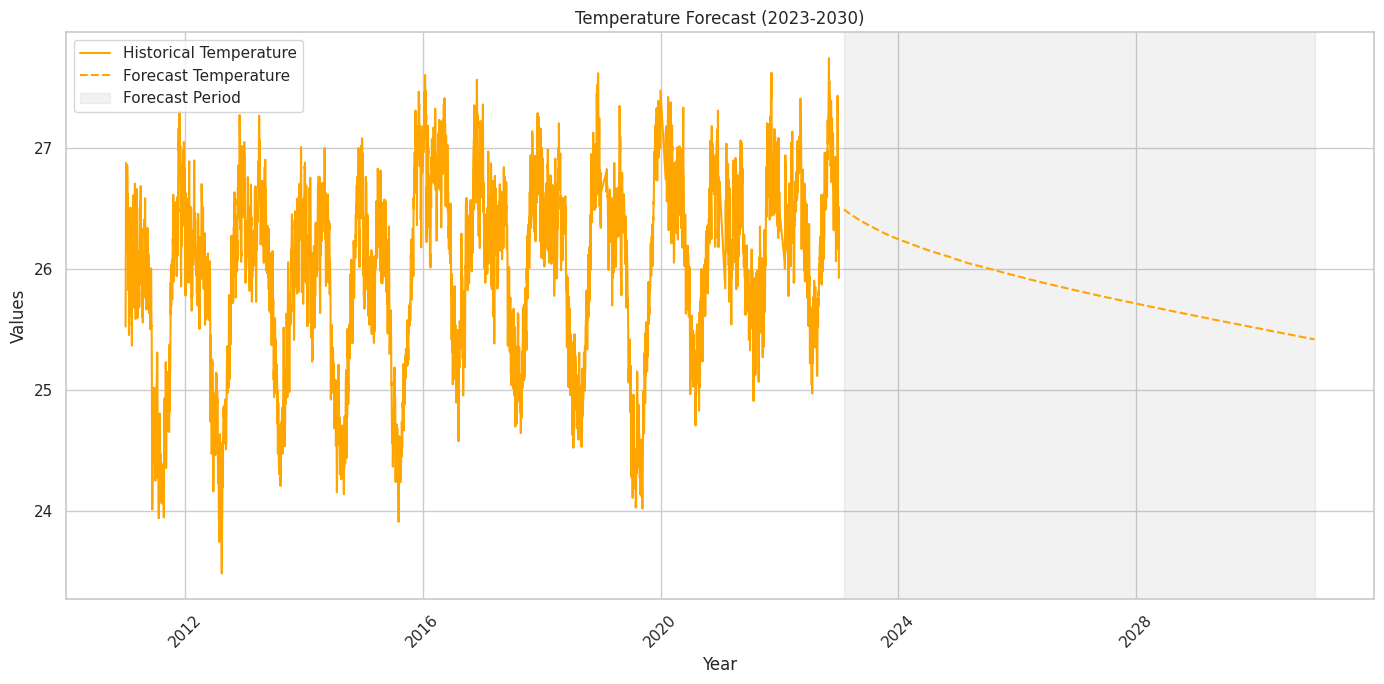

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
# sns.lineplot(x=papua.index, y=papua['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
sns.lineplot(x=papua.index, y=papua['Avg_Temperature'], label='Historical Temperature', color='orange')

# Plot future forecast with shading
# sns.lineplot(x=future_papua.index, y=future_papua['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
sns.lineplot(x=future_papua.index, y=future_papua['Avg_Temperature'], label='Forecast Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_papua.index[0], future_papua.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Temperature Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


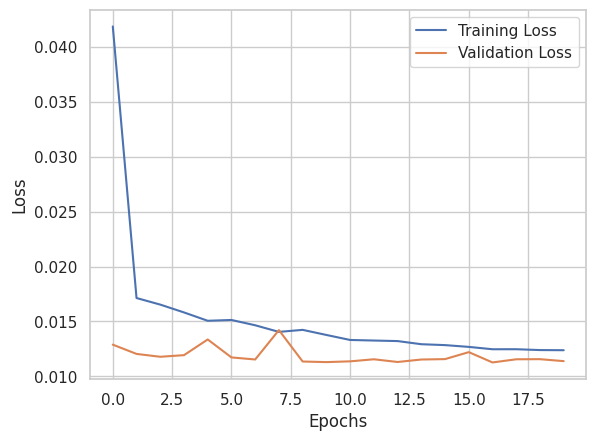

In [ ]:
plt.plot(histori_papua.history['loss'], label='Training Loss')
plt.plot(histori_papua.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Kalbar

In [ ]:
# Load your dataset and preprocess
kalbar = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/datasolar/solarkalbar.csv')

# Create a 'Date' column
kalbar['Date'] = pd.to_datetime(kalbar[['Year', 'Month', 'Day']])
kalbar.set_index('Date', inplace=True)

# Normalize 'Avg_Radiation' and 'Avg_Temperature'
kalbar_lstm = kalbar[['Avg_Radiation', 'Avg_Temperature']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(kalbar_lstm)

# Create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2))

# Compile and train
model.compile(optimizer='adam', loss='mean_squared_error')
histori_kalbar = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Forecast future data (2023-2030)
future_steps = 8 * 12  # 8 years monthly forecast
future_data = []
input_seq = X_test[-1]  # Start with the last sequence in test data
for _ in range(future_steps):
    pred = model.predict(input_seq.reshape(1, time_steps, 2))
    future_data.append(pred[0])
    input_seq = np.append(input_seq[1:], [pred[0]], axis=0)

# Inverse transform to get original scale values
future_data = np.array(future_data)
future_data_rescaled = scaler.inverse_transform(future_data)

# Create a future DataFrame with years and predictions
future_years = pd.date_range(start='2023-01-01', periods=future_steps, freq='M')
future_kalbar = pd.DataFrame(future_data_rescaled, columns=['Avg_Radiation', 'Avg_Temperature'], index=future_years)
print(future_kalbar)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0658 - val_loss: 0.0213
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0235 - val_loss: 0.0220
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0220 - val_loss: 0.0211
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0220 - val_loss: 0.0206
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0218 - val_loss: 0.0216
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0212 - val_loss: 0.0205
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0206 - val_loss: 0.0200
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0210 - val_loss: 0.0197
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0202 - val_loss: 0.0196
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0199 - val_loss: 0.0192
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0198 - val_loss: 0.0193
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/ste

In [ ]:
future_kalbar

Avg_Radiation  Avg_Temperature
2023-01-31       4.969176        25.021742
2023-02-28       4.984263        25.124483
2023-03-31       4.998727        25.177664
2023-04-30       5.010891        25.214725
2023-05-31       5.019513        25.242565
...                   ...              ...
2030-08-31       5.065080        25.541458
2030-09-30       5.065087        25.541563
2030-10-31       5.065094        25.541662
2030-11-30       5.065101        25.541756
2030-12-31       5.065107        25.541845

[96 rows x 2 columns]

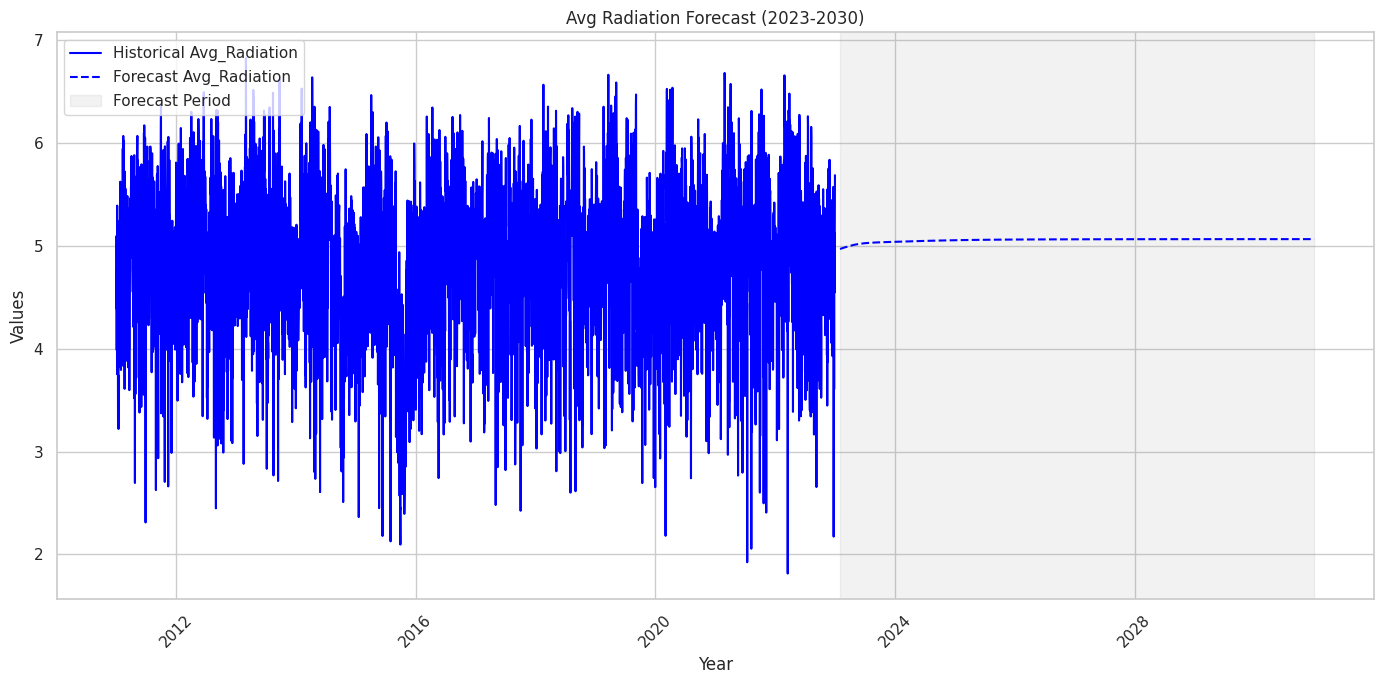

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
sns.lineplot(x=kalbar.index, y=kalbar['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
# sns.lineplot(x=kalbar.index, y=kalbar['Avg_Temperature'], label='Historical Avg_Temperature', color='orange')

# Plot future forecast with shading
sns.lineplot(x=future_kalbar.index, y=future_kalbar['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
# sns.lineplot(x=future_kalbar.index, y=future_kalbar['Avg_Temperature'], label='Forecast Avg_Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_kalbar.index[0], future_kalbar.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Avg Radiation Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


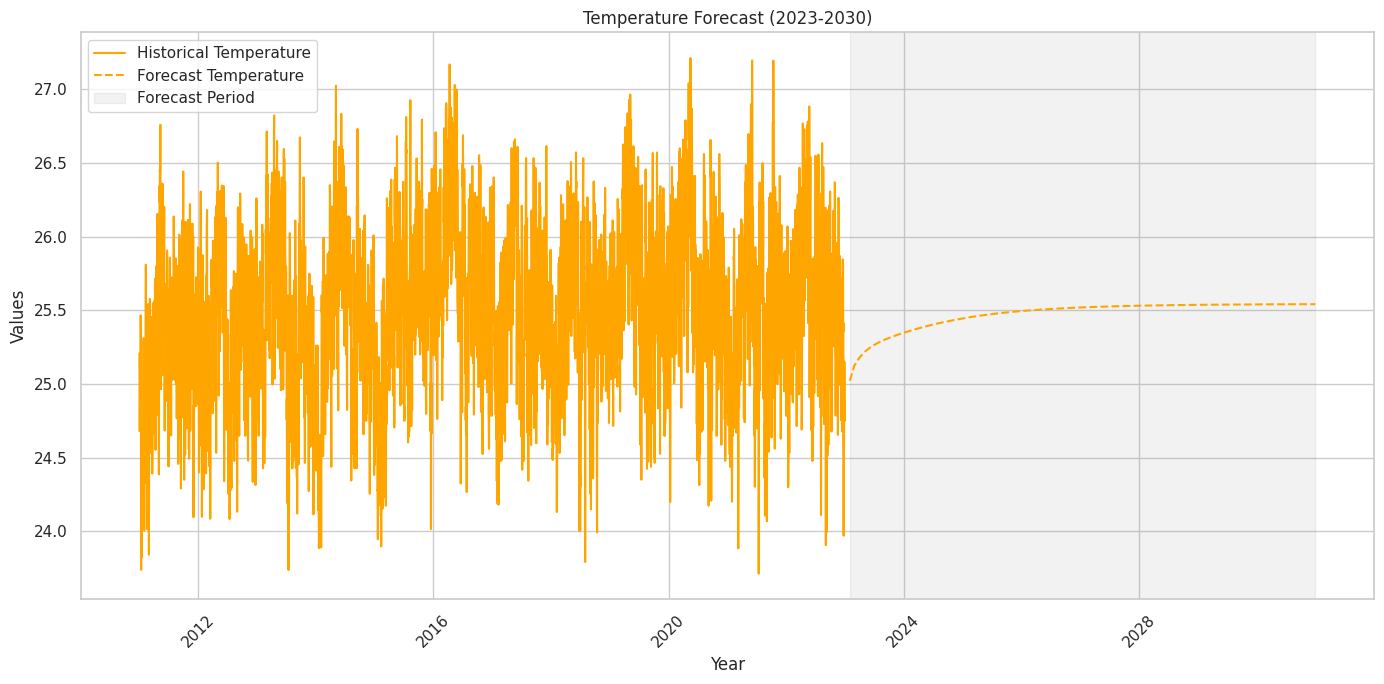

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
# sns.lineplot(x=papua.index, y=papua['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
sns.lineplot(x=kalbar.index, y=kalbar['Avg_Temperature'], label='Historical Temperature', color='orange')

# Plot future forecast with shading
# sns.lineplot(x=future_papua.index, y=future_papua['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
sns.lineplot(x=future_kalbar.index, y=future_kalbar['Avg_Temperature'], label='Forecast Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_kalbar.index[0], future_kalbar.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Temperature Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


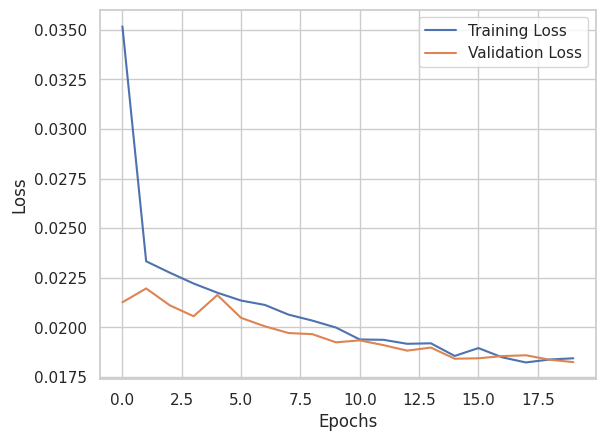

In [ ]:
plt.plot(histori_kalbar.history['loss'], label='Training Loss')
plt.plot(histori_kalbar.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Maluku

In [ ]:
# Load your dataset and preprocess
maluku = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/datasolar/solarmaluku.csv')

# Create a 'Date' column
maluku['Date'] = pd.to_datetime(maluku[['Year', 'Month', 'Day']])
maluku.set_index('Date', inplace=True)

# Normalize 'Avg_Radiation' and 'Avg_Temperature'
maluku_lstm = maluku[['Avg_Radiation', 'Avg_Temperature']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(maluku_lstm)

# Create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2))

# Compile and train
model.compile(optimizer='adam', loss='mean_squared_error')
histori_maluku = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Forecast future data (2023-2030)
future_steps = 8 * 12  # 8 years monthly forecast
future_data = []
input_seq = X_test[-1]  # Start with the last sequence in test data
for _ in range(future_steps):
    pred = model.predict(input_seq.reshape(1, time_steps, 2))
    future_data.append(pred[0])
    input_seq = np.append(input_seq[1:], [pred[0]], axis=0)

# Inverse transform to get original scale values
future_data = np.array(future_data)
future_data_rescaled = scaler.inverse_transform(future_data)

# Create a future DataFrame with years and predictions
future_years = pd.date_range(start='2023-01-01', periods=future_steps, freq='M')
future_maluku = pd.DataFrame(future_data_rescaled, columns=['Avg_Radiation', 'Avg_Temperature'], index=future_years)
print(future_maluku)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0769 - val_loss: 0.0164
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0191 - val_loss: 0.0162
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0186 - val_loss: 0.0171
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0174 - val_loss: 0.0159
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0173 - val_loss: 0.0154
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0168 - val_loss: 0.0155
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0164 - val_loss: 0.0152
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/ste

In [ ]:
future_maluku

Avg_Radiation  Avg_Temperature
2023-01-31       4.632887        27.577509
2023-02-28       4.774059        27.643763
2023-03-31       4.862916        27.684439
2023-04-30       4.924632        27.717033
2023-05-31       4.966874        27.743181
...                   ...              ...
2030-08-31       5.417984        28.504122
2030-09-30       5.418433        28.505823
2030-10-31       5.418863        28.507458
2030-11-30       5.419274        28.509027
2030-12-31       5.419669        28.510536

[96 rows x 2 columns]

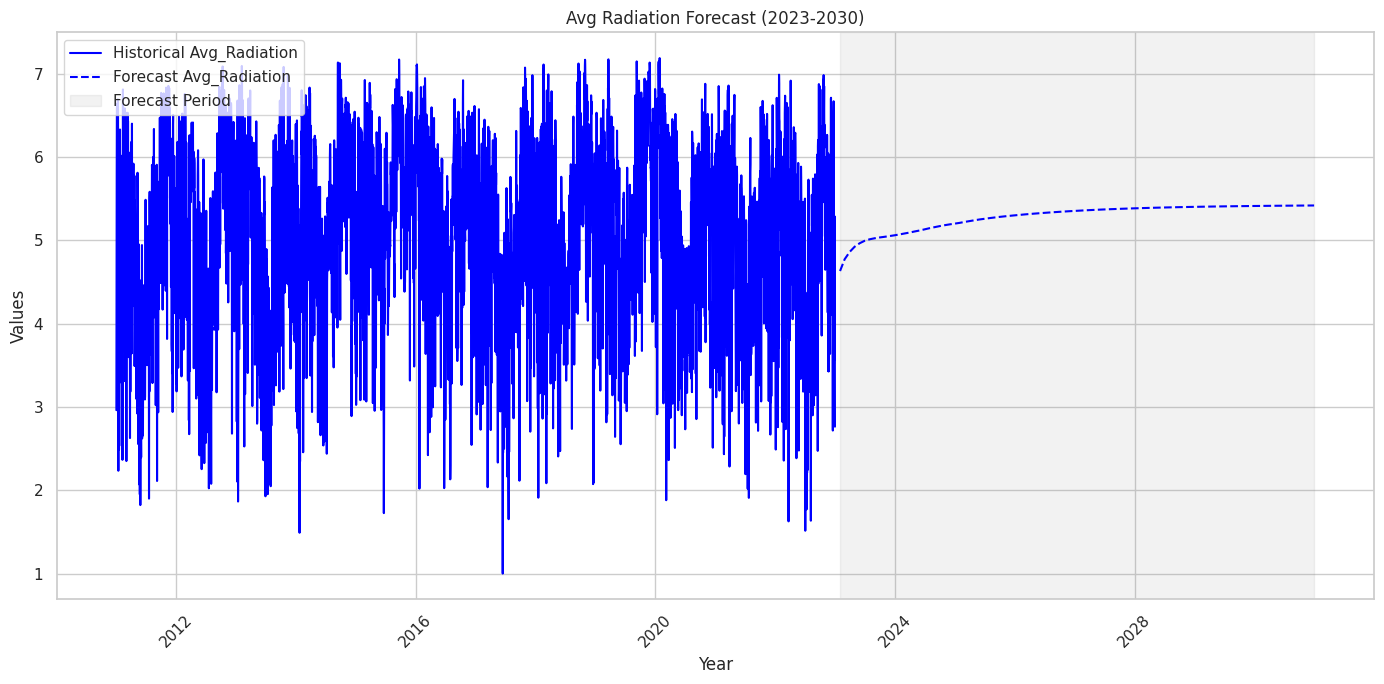

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
sns.lineplot(x=maluku.index, y=maluku['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
# sns.lineplot(x=maluku.index, y=maluku['Avg_Temperature'], label='Historical Avg_Temperature', color='orange')

# Plot future forecast with shading
sns.lineplot(x=future_maluku.index, y=future_maluku['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
# sns.lineplot(x=future_maluku.index, y=future_maluku['Avg_Temperature'], label='Forecast Avg_Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_maluku.index[0], future_maluku.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Avg Radiation Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


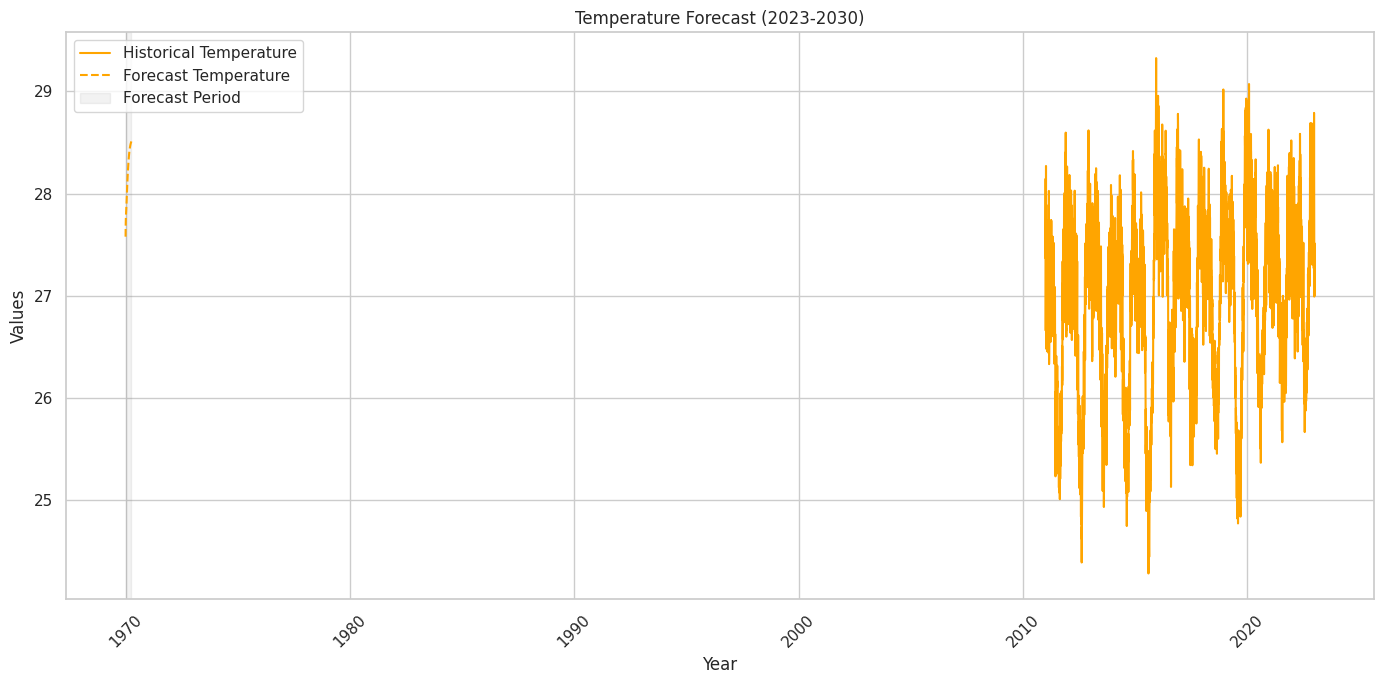

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
# sns.lineplot(x=papua.index, y=papua['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
sns.lineplot(x=maluku.index, y=maluku['Avg_Temperature'], label='Historical Temperature', color='orange')

# Plot future forecast with shading
# sns.lineplot(x=future_papua.index, y=future_papua['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
sns.lineplot(x=future_maluku.index, y=future_maluku['Avg_Temperature'], label='Forecast Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_maluku.index[0], future_maluku.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Temperature Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


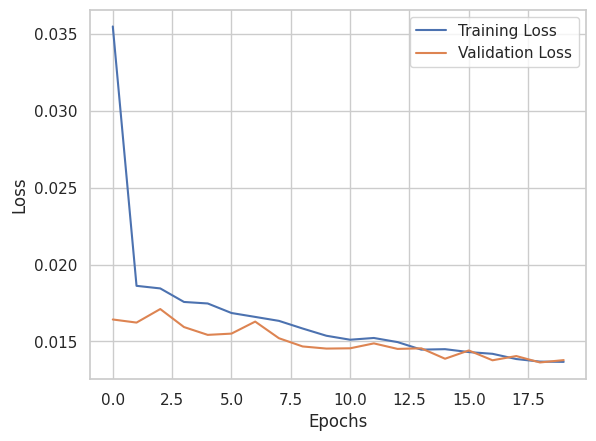

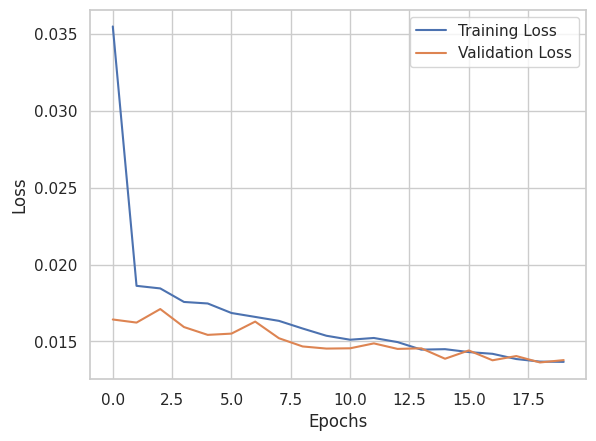

In [ ]:
plt.plot(histori_maluku.history['loss'], label='Training Loss')
plt.plot(histori_maluku.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Sumatera Utara

In [ ]:
# Load your dataset and preprocess
sumut = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/datasolar/solarsumut.csv')

# Create a 'Date' column
sumut['Date'] = pd.to_datetime(sumut[['Year', 'Month', 'Day']])
sumut.set_index('Date', inplace=True)

# Normalize 'Avg_Radiation' and 'Avg_Temperature'
sumut_lstm = sumut[['Avg_Radiation', 'Avg_Temperature']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sumut_lstm)

# Create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2))

# Compile and train
model.compile(optimizer='adam', loss='mean_squared_error')
histori_sumut = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Forecast future data (2023-2030)
future_steps = 8 * 12  # 8 years monthly forecast
future_data = []
input_seq = X_test[-1]  # Start with the last sequence in test data
for _ in range(future_steps):
    pred = model.predict(input_seq.reshape(1, time_steps, 2))
    future_data.append(pred[0])
    input_seq = np.append(input_seq[1:], [pred[0]], axis=0)

# Inverse transform to get original scale values
future_data = np.array(future_data)
future_data_rescaled = scaler.inverse_transform(future_data)

# Create a future DataFrame with years and predictions
future_years = pd.date_range(start='2023-01-01', periods=future_steps, freq='M')
future_sumut = pd.DataFrame(future_data_rescaled, columns=['Avg_Radiation', 'Avg_Temperature'], index=future_years)
print(future_sumut)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0819 - val_loss: 0.0179
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0214 - val_loss: 0.0169
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0200 - val_loss: 0.0169
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0185 - val_loss: 0.0170
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0185 - val_loss: 0.0168
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0184 - val_loss: 0.0169
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0179 - val_loss: 0.0170
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0180 - val_loss: 0.0167
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0181 - val_loss: 0.0164
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0168 - val_loss: 0.0164
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0163 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.1182 - val_loss: 0.0183
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0217 - val_loss: 0.0168
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0192 - val_loss: 0.0168
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0195 - val_loss: 0.0169
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0184 - val_loss: 0.0167
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0183 - val_loss: 0.0165
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0182 - val_loss: 0.0168
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0176 - val_loss: 0.0162
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0177 - val_loss: 0.0162
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0176 - val_loss: 0.0161
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0172 - val_l

In [ ]:
future_sumut

Avg_Radiation  Avg_Temperature
2023-01-31       4.382653        23.776457
2023-02-28       4.432306        23.764408
2023-03-31       4.486762        23.780800
2023-04-30       4.539790        23.807688
2023-05-31       4.589162        23.837894
...                   ...              ...
2030-08-31       4.994055        24.263502
2030-09-30       4.994338        24.264236
2030-10-31       4.994611        24.264950
2030-11-30       4.994876        24.265644
2030-12-31       4.995134        24.266319

[96 rows x 2 columns]

Avg_Radiation  Avg_Temperature
2023-01-31       4.211776        23.658546
2023-02-28       4.263748        23.658033
2023-03-31       4.311200        23.675613
2023-04-30       4.352894        23.696976
2023-05-31       4.388555        23.717747
...                   ...              ...
2030-08-31       4.590869        23.899893
2030-09-30       4.590910        23.900105
2030-10-31       4.590949        23.900305
2030-11-30       4.590986        23.900501
2030-12-31       4.591021        23.900690

[96 rows x 2 columns]

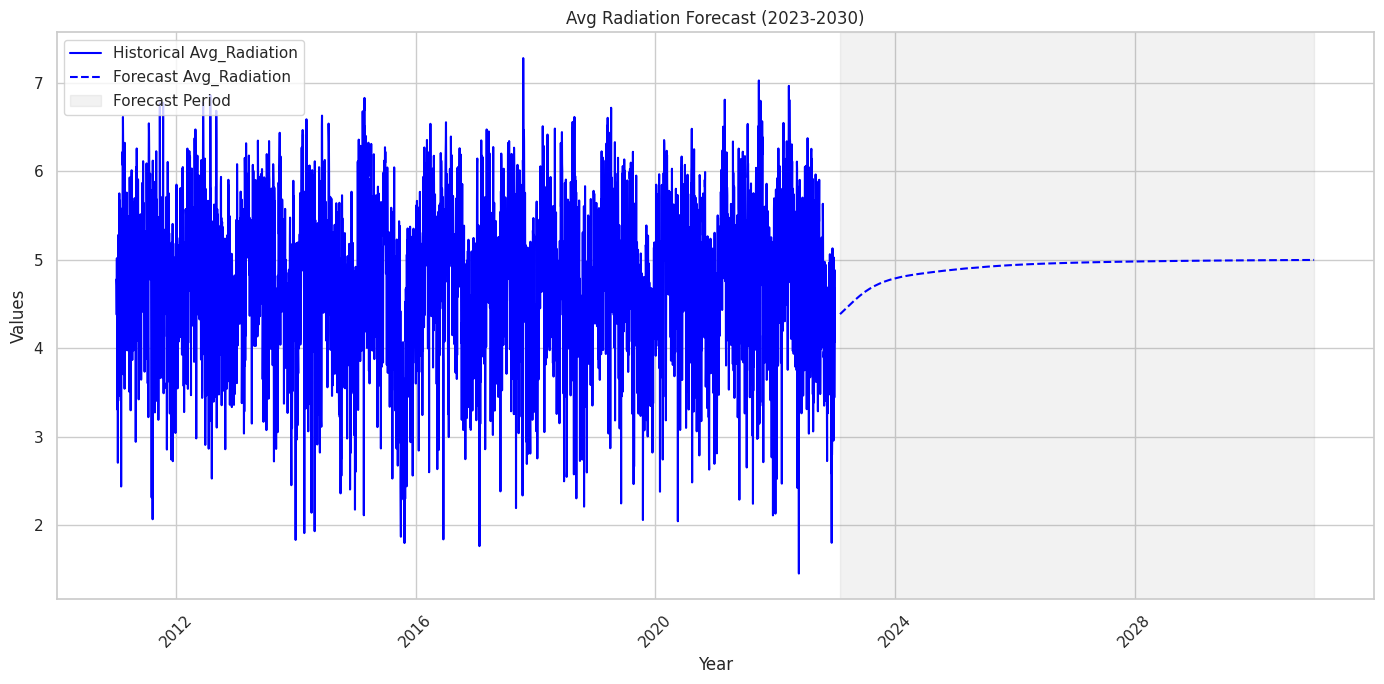

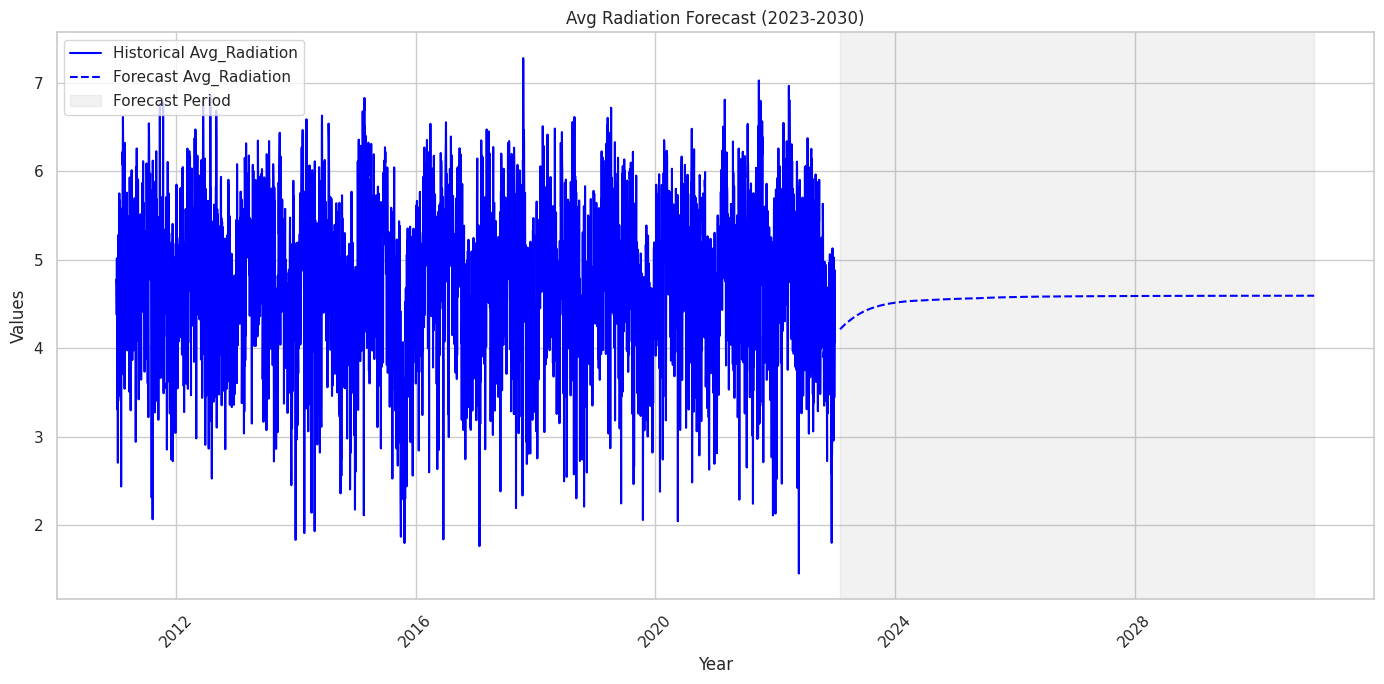

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
sns.lineplot(x=sumut.index, y=sumut['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
# sns.lineplot(x=sumut.index, y=sumut['Avg_Temperature'], label='Historical Avg_Temperature', color='orange')

# Plot future forecast with shading
sns.lineplot(x=future_sumut.index, y=future_sumut['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
# sns.lineplot(x=future_sumut.index, y=future_sumut['Avg_Temperature'], label='Forecast Avg_Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_sumut.index[0], future_sumut.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Avg Radiation Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


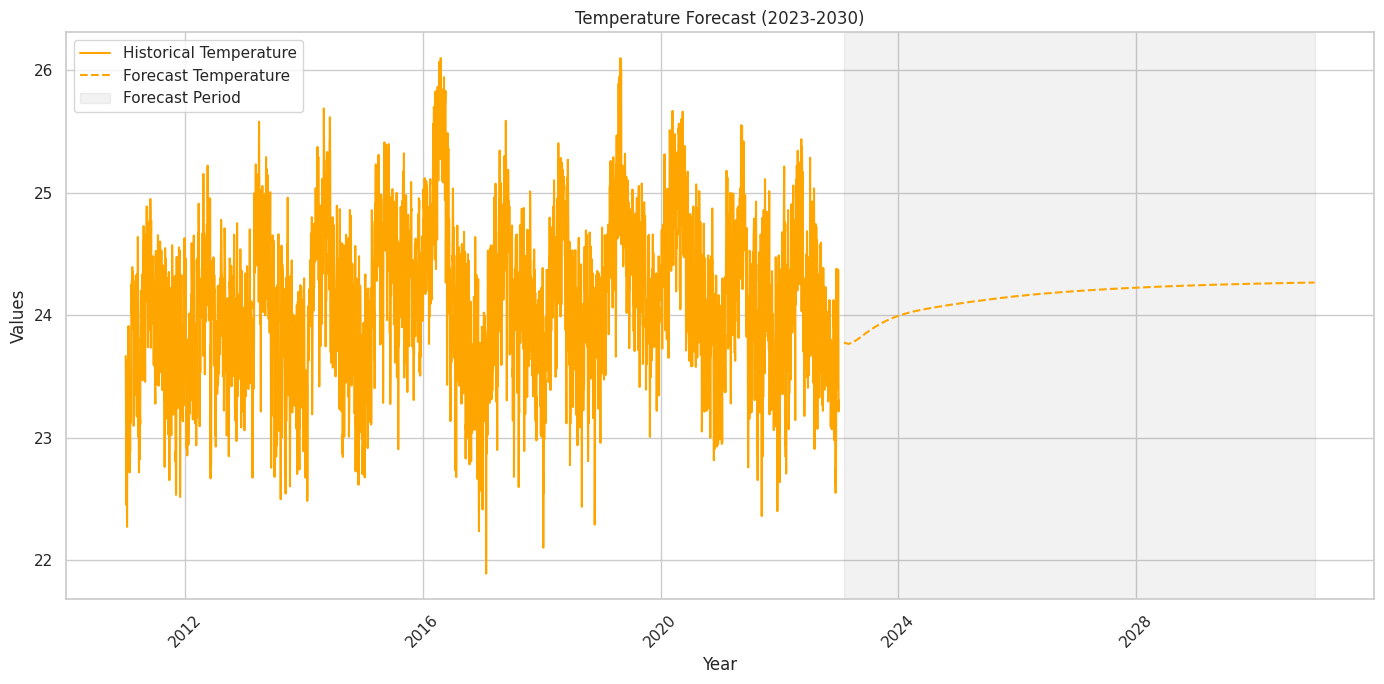

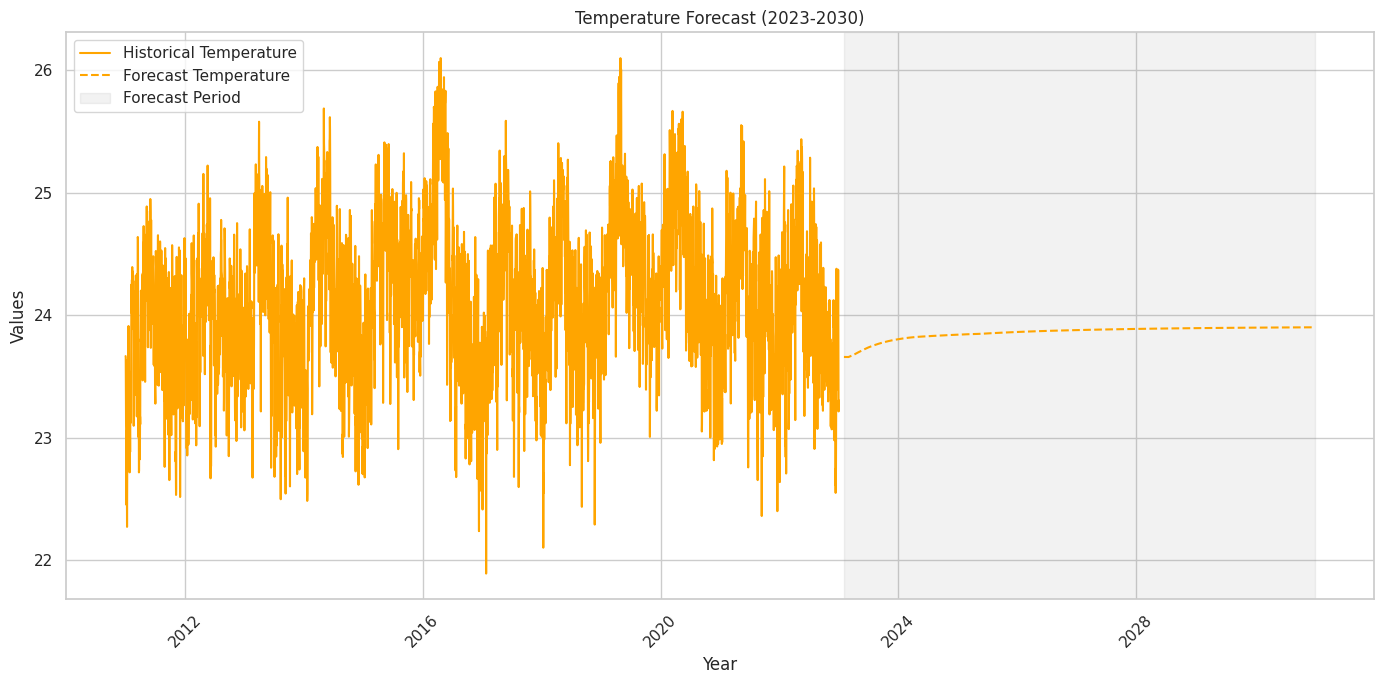

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
# sns.lineplot(x=papua.index, y=papua['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
sns.lineplot(x=sumut.index, y=sumut['Avg_Temperature'], label='Historical Temperature', color='orange')

# Plot future forecast with shading
# sns.lineplot(x=future_papua.index, y=future_papua['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
sns.lineplot(x=future_sumut.index, y=future_sumut['Avg_Temperature'], label='Forecast Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_sumut.index[0], future_sumut.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Temperature Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


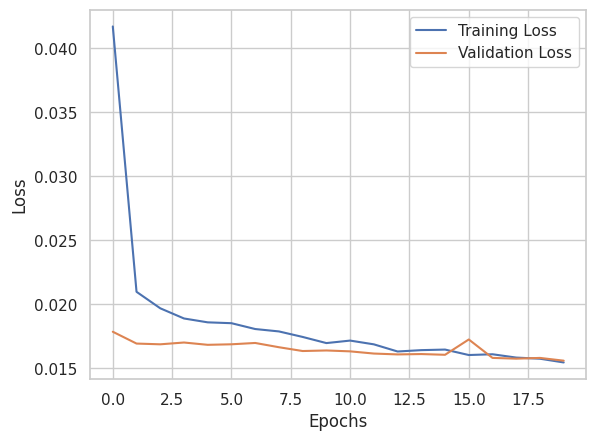

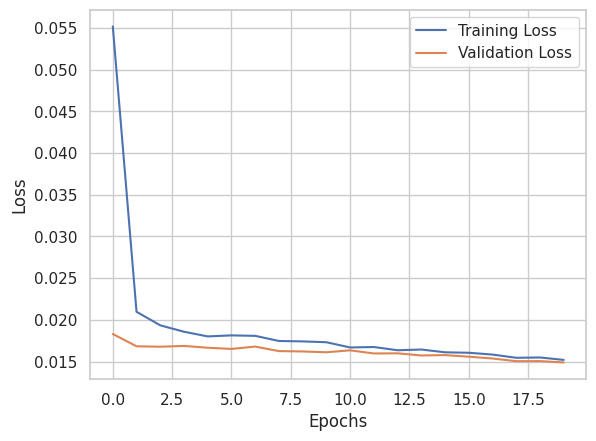

In [ ]:
plt.plot(histori_sumut.history['loss'], label='Training Loss')
plt.plot(histori_sumut.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### NTT

In [ ]:
# Load your dataset and preprocess
ntt = pd.read_csv('/content/drive/MyDrive/Penyisihan TSA/datasolar/solarntt.csv')

# Create a 'Date' column
ntt['Date'] = pd.to_datetime(ntt[['Year', 'Month', 'Day']])
ntt.set_index('Date', inplace=True)

# Normalize 'Avg_Radiation' and 'Avg_Temperature'
ntt_lstm = ntt[['Avg_Radiation', 'Avg_Temperature']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ntt_lstm)

# Create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=2))

# Compile and train
model.compile(optimizer='adam', loss='mean_squared_error')
histori_ntt = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Forecast future data (2023-2030)
future_steps = 8 * 12  # 8 years monthly forecast
future_data = []
input_seq = X_test[-1]  # Start with the last sequence in test data
for _ in range(future_steps):
    pred = model.predict(input_seq.reshape(1, time_steps, 2))
    future_data.append(pred[0])
    input_seq = np.append(input_seq[1:], [pred[0]], axis=0)

# Inverse transform to get original scale values
future_data = np.array(future_data)
future_data_rescaled = scaler.inverse_transform(future_data)

# Create a future DataFrame with years and predictions
future_years = pd.date_range(start='2023-01-01', periods=future_steps, freq='M')
future_ntt = pd.DataFrame(future_data_rescaled, columns=['Avg_Radiation', 'Avg_Temperature'], index=future_years)
print(future_ntt)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0833 - val_loss: 0.0107
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0145 - val_loss: 0.0099
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0126 - val_loss: 0.0098
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0120 - val_loss: 0.0097
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0119 - val_loss: 0.0092
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0107 - val_loss: 0.0096
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0108 - val_loss: 0.0087
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0105 - val_loss: 0.0085
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0099 - val_loss: 0.0084
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0100 - val_loss: 0.0080
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.1070 - val_loss: 0.0109
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0150 - val_loss: 0.0105
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0131 - val_loss: 0.0102
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0135 - val_loss: 0.0098
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0123 - val_loss: 0.0100
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0117 - val_loss: 0.0092
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0111 - val_loss: 0.0088
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0105 - val_loss: 0.0084
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0099 - val_loss: 0.0080
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/ste

In [ ]:
future_ntt

Avg_Radiation  Avg_Temperature
2023-01-31       4.624133        27.629984
2023-02-28       4.675975        27.614685
2023-03-31       4.731394        27.598236
2023-04-30       4.773182        27.578197
2023-05-31       4.802094        27.555462
...                   ...              ...
2030-08-31       4.996225        26.510187
2030-09-30       4.996481        26.503529
2030-10-31       4.996729        26.496914
2030-11-30       4.996968        26.490339
2030-12-31       4.997197        26.483803

[96 rows x 2 columns]

Avg_Radiation  Avg_Temperature
2023-01-31       4.795493        27.582588
2023-02-28       4.900514        27.587208
2023-03-31       5.004118        27.575663
2023-04-30       5.084741        27.553919
2023-05-31       5.143841        27.527330
...                   ...              ...
2030-08-31       5.996076        27.260088
2030-09-30       5.997555        27.264204
2030-10-31       5.998941        27.268290
2030-11-30       6.000236        27.272333
2030-12-31       6.001441        27.276340

[96 rows x 2 columns]

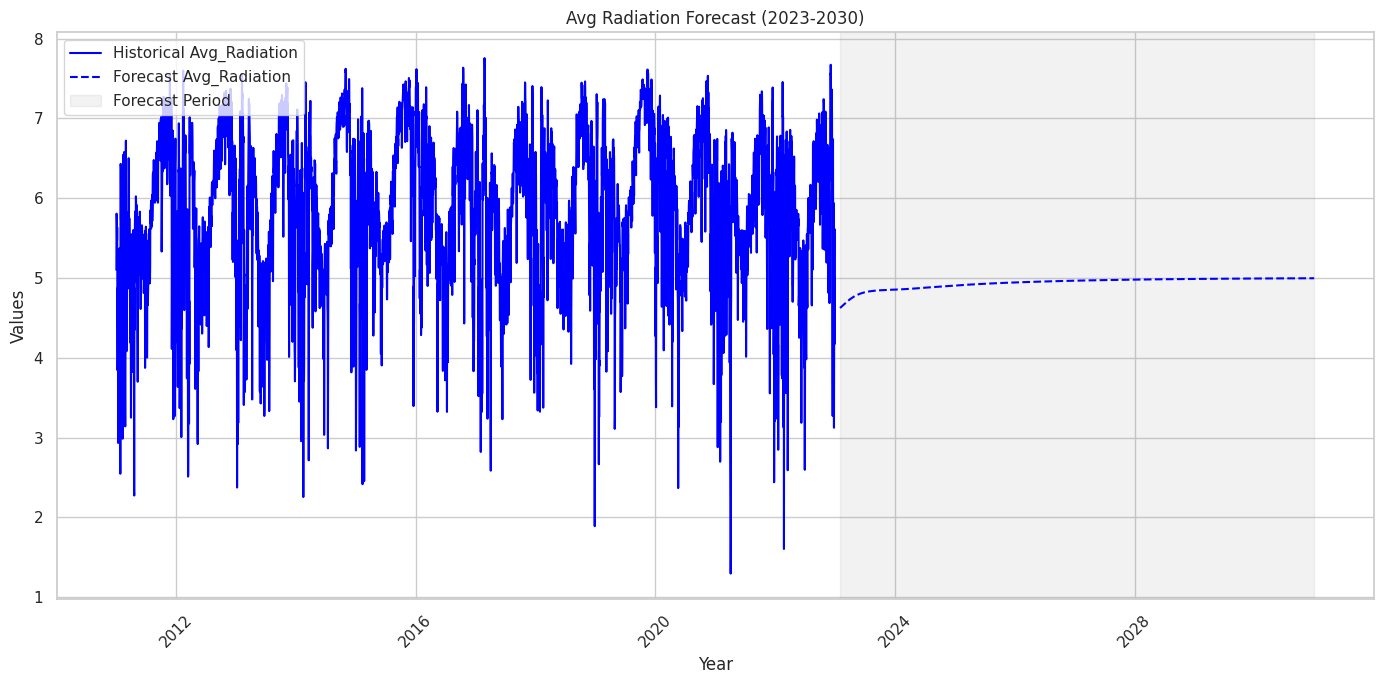

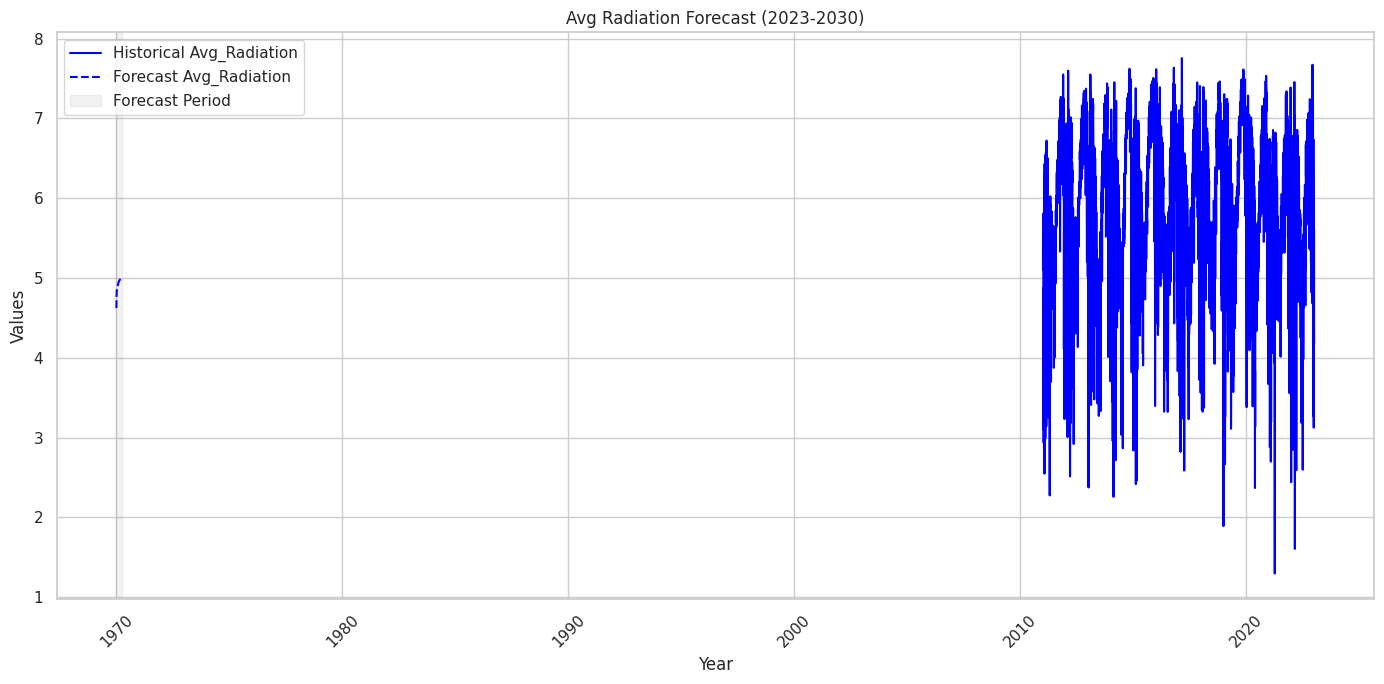

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
sns.lineplot(x=ntt.index, y=ntt['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
# sns.lineplot(x=ntt.index, y=ntt['Avg_Temperature'], label='Historical Avg_Temperature', color='orange')

# Plot future forecast with shading
sns.lineplot(x=future_ntt.index, y=future_ntt['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
# sns.lineplot(x=future_ntt.index, y=future_ntt['Avg_Temperature'], label='Forecast Avg_Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_ntt.index[0], future_ntt.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Avg Radiation Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


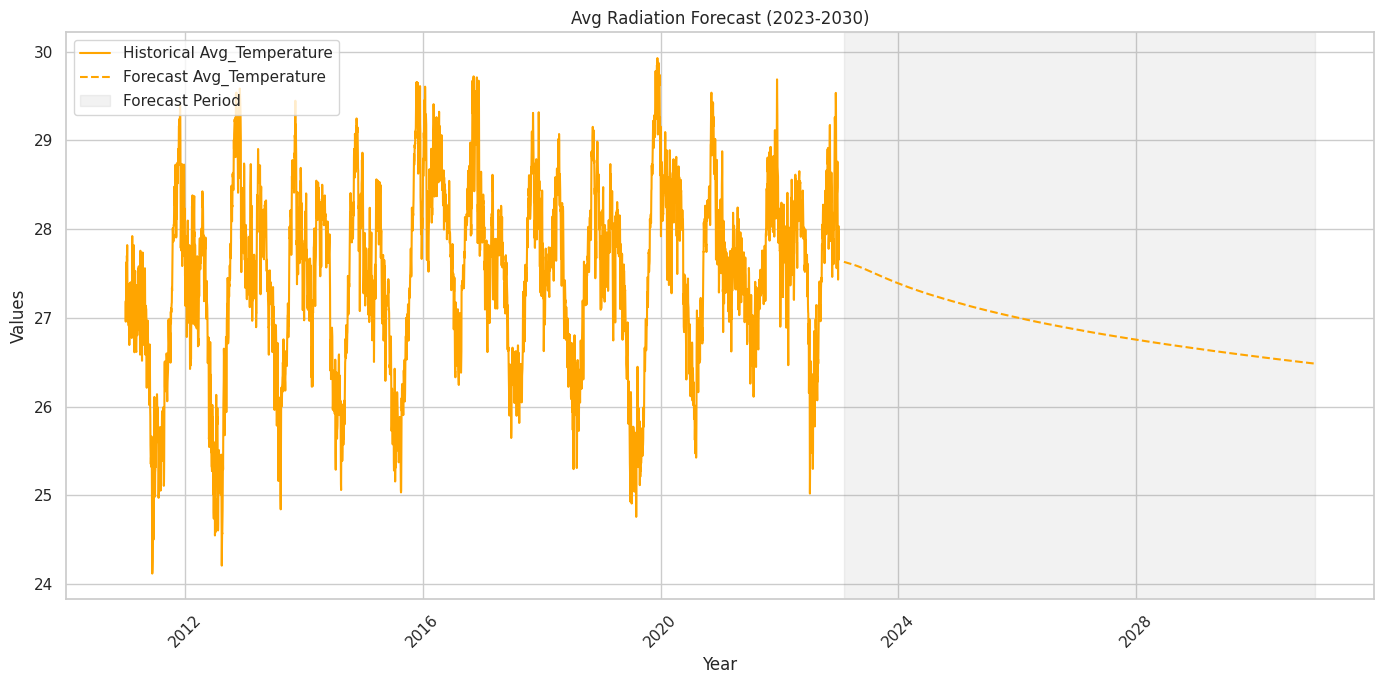

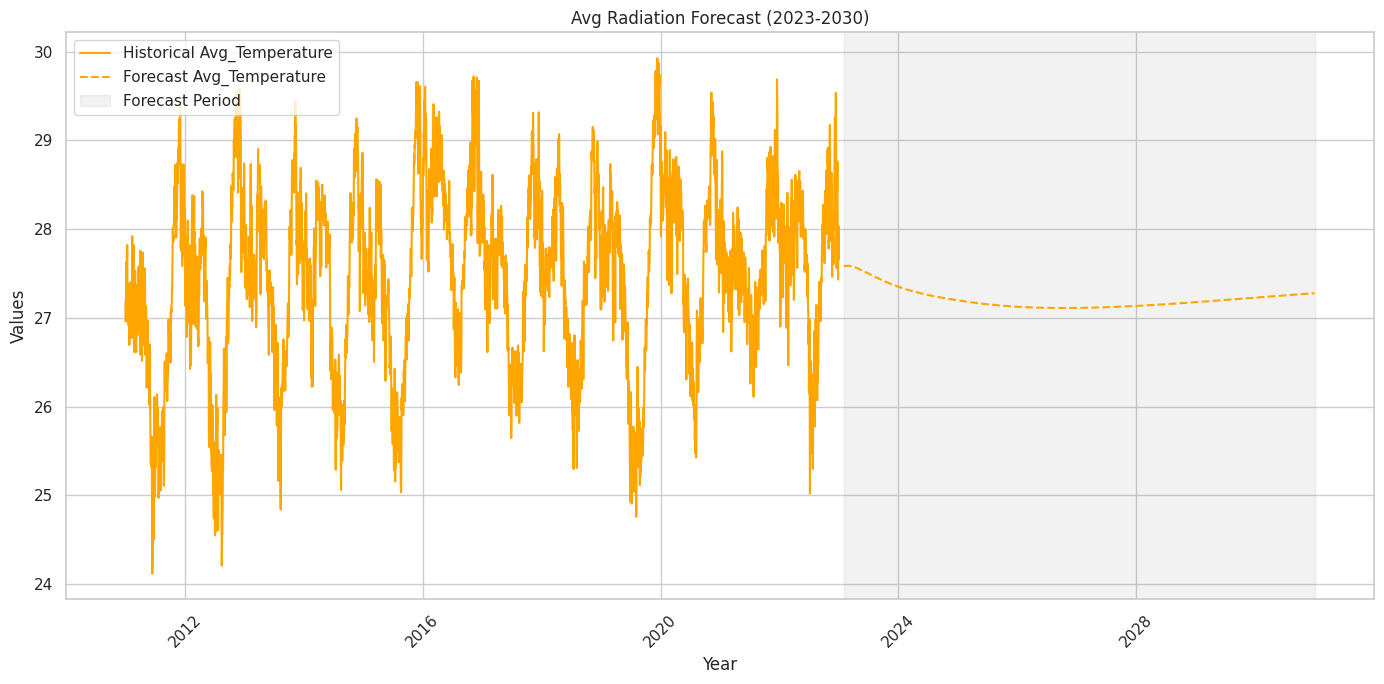

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style='whitegrid')

# Create a figure
plt.figure(figsize=(14, 7))

# Plot historical Avg_Radiation and Avg_Temperature
# sns.lineplot(x=ntt.index, y=ntt['Avg_Radiation'], label='Historical Avg_Radiation', color='blue')
sns.lineplot(x=ntt.index, y=ntt['Avg_Temperature'], label='Historical Avg_Temperature', color='orange')

# Plot future forecast with shading
# sns.lineplot(x=future_ntt.index, y=future_ntt['Avg_Radiation'], label='Forecast Avg_Radiation', linestyle='--', color='blue')
sns.lineplot(x=future_ntt.index, y=future_ntt['Avg_Temperature'], label='Forecast Avg_Temperature', linestyle='--', color='orange')

# Add shading to show the forecast period
plt.axvspan(future_ntt.index[0], future_ntt.index[-1], color='gray', alpha=0.1, label='Forecast Period')

# Customize plot
plt.title('Avg Radiation Forecast (2023-2030)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


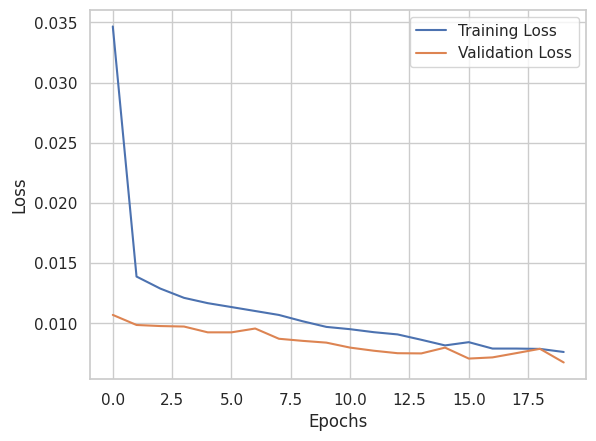

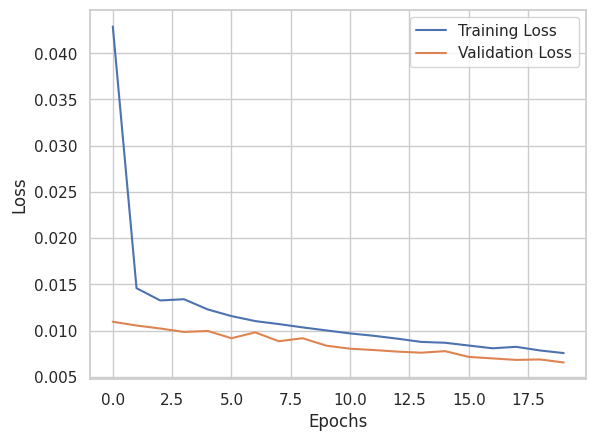

In [ ]:
plt.plot(histori_ntt.history['loss'], label='Training Loss')
plt.plot(histori_ntt.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prophet

In [ ]:
! pip install prophet
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Papua

In [ ]:
papua.head()

Year  Month  Day  Avg_Radiation  Avg_Temperature
Date                                                        
2011-01-01  2011      1    1       4.517667        25.524100
2011-01-02  2011      1    2       4.673600        25.886667
2011-01-03  2011      1    3       5.600800        26.376433
2011-01-04  2011      1    4       6.650333        26.878367
2011-01-05  2011      1    5       5.521333        26.782533

Year  Month  Day  Avg_Radiation  Avg_Temperature
Date                                                        
2011-01-01  2011      1    1       4.517667        25.524100
2011-01-02  2011      1    2       4.673600        25.886667
2011-01-03  2011      1    3       5.600800        26.376433
2011-01-04  2011      1    4       6.650333        26.878367
2011-01-05  2011      1    5       5.521333        26.782533

Prediksi data radiasi papua

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/0kj_gili.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/z4uop7ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31139', 'data', 'file=/tmp/tmpfw5lgztm/0kj_gili.json', 'init=/tmp/tmpfw5lgztm/z4uop7ns.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_model_3ier5df/prophet_model-20241019033341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

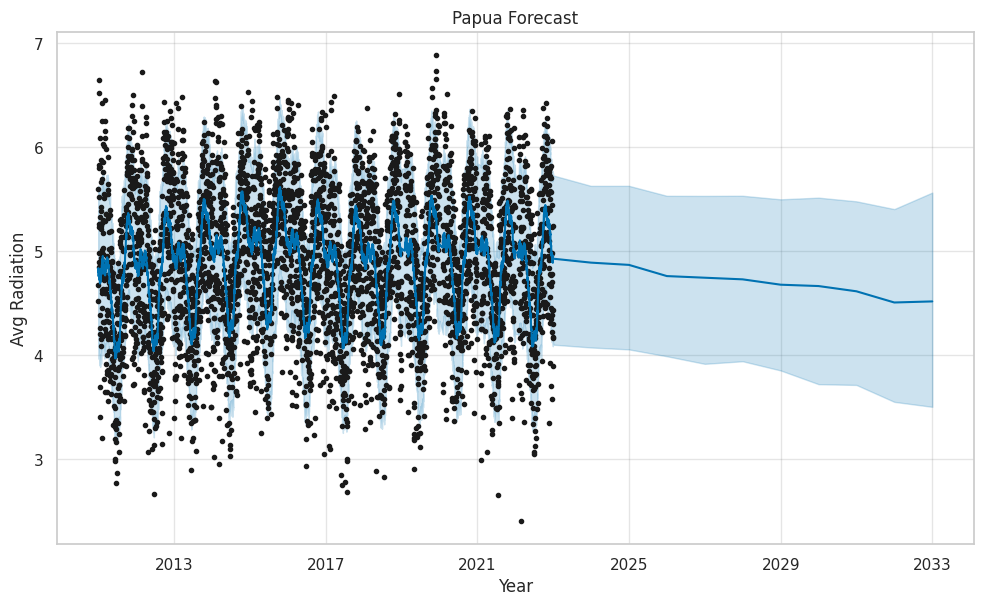

Error Metrics:
         Metric      Value
0           MAE   0.498713
1           MSE   0.381846
2          RMSE   0.617937
3  Accuracy (%)  89.267919


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/ct5t4nje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/0umo94g6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69029', 'data', 'file=/tmp/tmpfw5lgztm/ct5t4nje.json', 'init=/tmp/tmpfw5lgztm/0umo94g6.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modeld7uy5ts5/prophet_model-20241019034308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:43:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

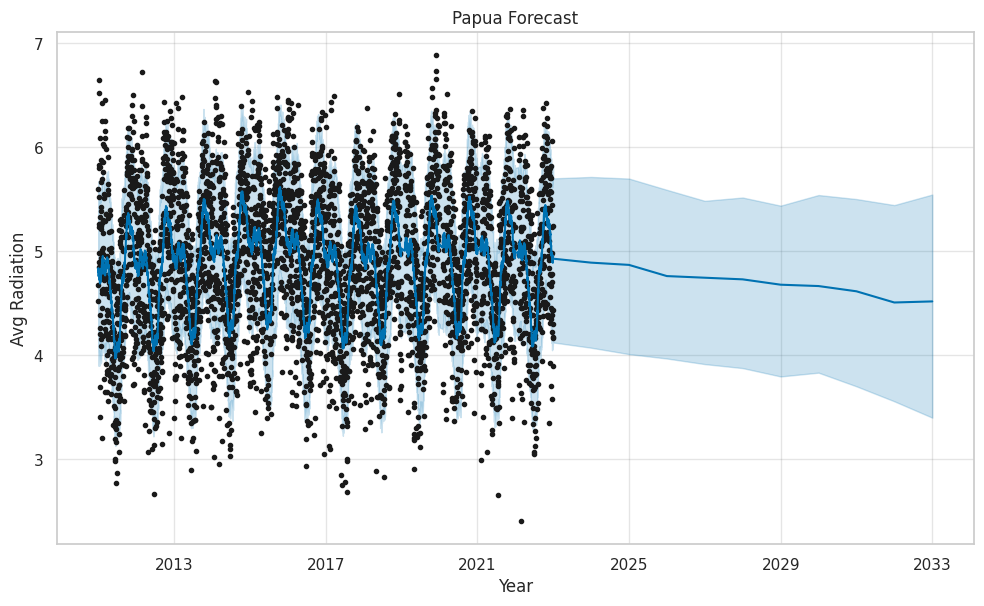

Error Metrics:
         Metric      Value
0           MAE   0.498713
1           MSE   0.381846
2          RMSE   0.617937
3  Accuracy (%)  89.267919


In [ ]:
# Prepare the data for Prophet
papua_rad = papua.reset_index()[['Date', 'Avg_Radiation']] # Reset the index to make 'Date' a column
papua_rad = papua_rad.rename(columns={'Date': 'ds', 'Avg_Radiation': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(papua_rad)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
papua_rad_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = papua_rad['y'].values
predicted = papua_rad_forecast['yhat'][:len(papua_rad)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(papua_rad_forecast)
plt.title("Papua Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Radiation")
plt.show()

# Display forecasted results
forecast_results = papua_rad_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

Prediksi data temperatur papua

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/infgx0es.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/d0jqbr_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75131', 'data', 'file=/tmp/tmpfw5lgztm/infgx0es.json', 'init=/tmp/tmpfw5lgztm/d0jqbr_s.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelqr6lt0wy/prophet_model-20241019033347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

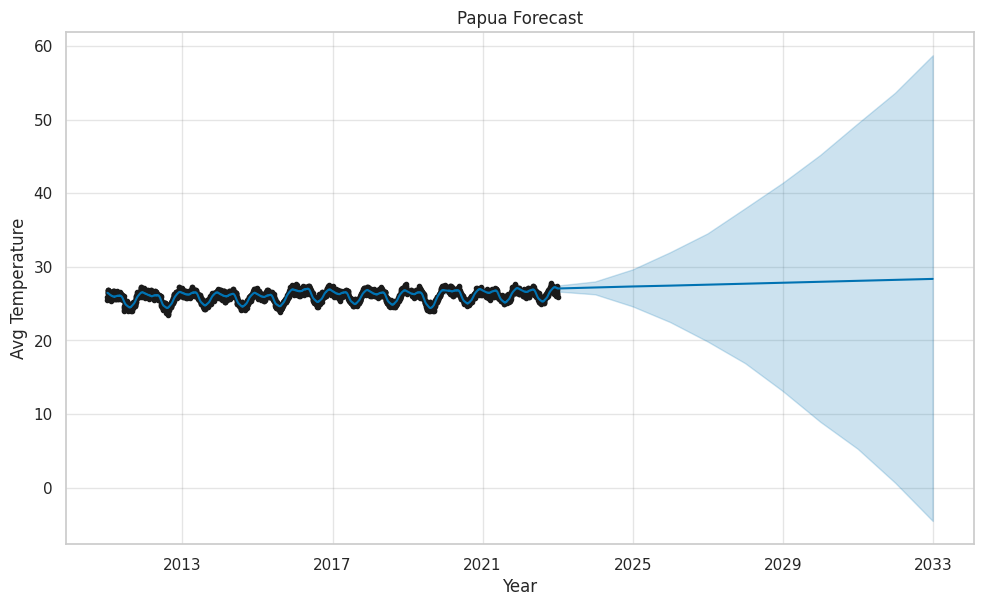

Error Metrics:
         Metric      Value
0           MAE   0.256324
1           MSE   0.101063
2          RMSE   0.317904
3  Accuracy (%)  99.014274


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/o1og0l1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/dyj10b09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88332', 'data', 'file=/tmp/tmpfw5lgztm/o1og0l1f.json', 'init=/tmp/tmpfw5lgztm/dyj10b09.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_model6u8k7che/prophet_model-20241019034312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:43:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

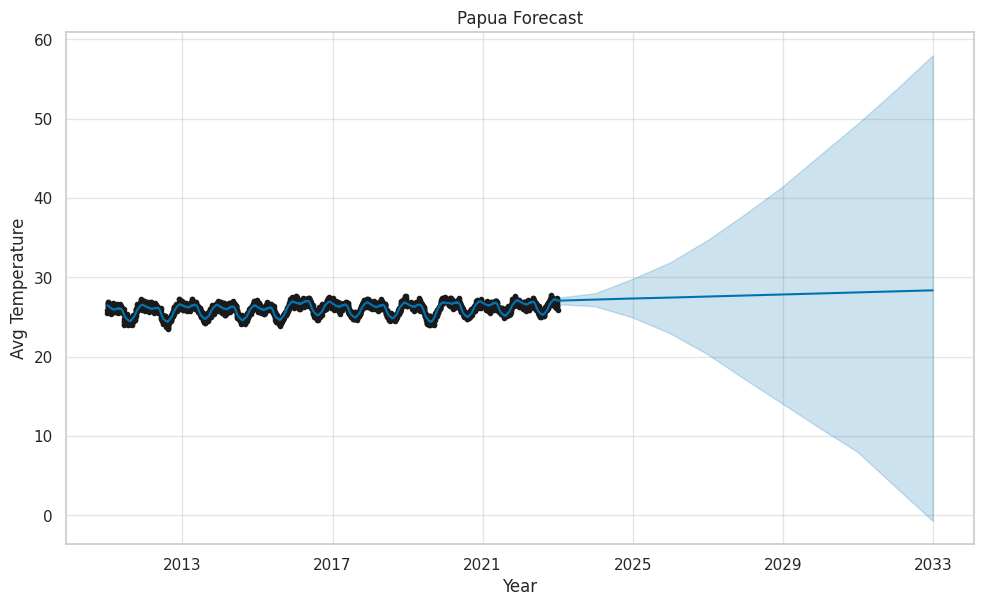

Error Metrics:
         Metric      Value
0           MAE   0.256324
1           MSE   0.101063
2          RMSE   0.317904
3  Accuracy (%)  99.014274


In [ ]:
# Prepare the data for Prophet
papua_temp = papua.reset_index()[['Date', 'Avg_Temperature']] # Reset the index to make 'Date' a column
papua_temp = papua_temp.rename(columns={'Date': 'ds', 'Avg_Temperature': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(papua_temp)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
papua_temp_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = papua_temp['y'].values
predicted = papua_temp_forecast['yhat'][:len(papua_temp)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(papua_temp_forecast)
plt.title("Papua Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Temperature")
plt.show()

# Display forecasted results
forecast_results = papua_temp_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

### Kalbar

In [ ]:
kalbar

Year  Month  Day  Avg_Radiation  Avg_Temperature
Date                                                        
2011-01-01  2011      1    1       3.991333        24.681556
2011-01-02  2011      1    2       5.096667        25.148444
2011-01-03  2011      1    3       4.386444        25.211111
2011-01-04  2011      1    4       4.773556        25.129333
2011-01-05  2011      1    5       3.752444        25.018889
...          ...    ...  ...            ...              ...
2022-12-27  2022     12   27       5.127556        24.976000
2022-12-28  2022     12   28       4.545333        25.152667
2022-12-29  2022     12   29       4.730667        25.103111
2022-12-30  2022     12   30       5.292667        24.749111
2022-12-31  2022     12   31       5.686667        24.881111

[4383 rows x 5 columns]

Year  Month  Day  Avg_Radiation  Avg_Temperature
Date                                                        
2011-01-01  2011      1    1       3.991333        24.681556
2011-01-02  2011      1    2       5.096667        25.148444
2011-01-03  2011      1    3       4.386444        25.211111
2011-01-04  2011      1    4       4.773556        25.129333
2011-01-05  2011      1    5       3.752444        25.018889
...          ...    ...  ...            ...              ...
2022-12-27  2022     12   27       5.127556        24.976000
2022-12-28  2022     12   28       4.545333        25.152667
2022-12-29  2022     12   29       4.730667        25.103111
2022-12-30  2022     12   30       5.292667        24.749111
2022-12-31  2022     12   31       5.686667        24.881111

[4383 rows x 5 columns]

Prediksi data radiasi kalbar

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/q_9xykrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/lnidd1eh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3872', 'data', 'file=/tmp/tmpfw5lgztm/q_9xykrn.json', 'init=/tmp/tmpfw5lgztm/lnidd1eh.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelqmfd2_t0/prophet_model-20241019033356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a

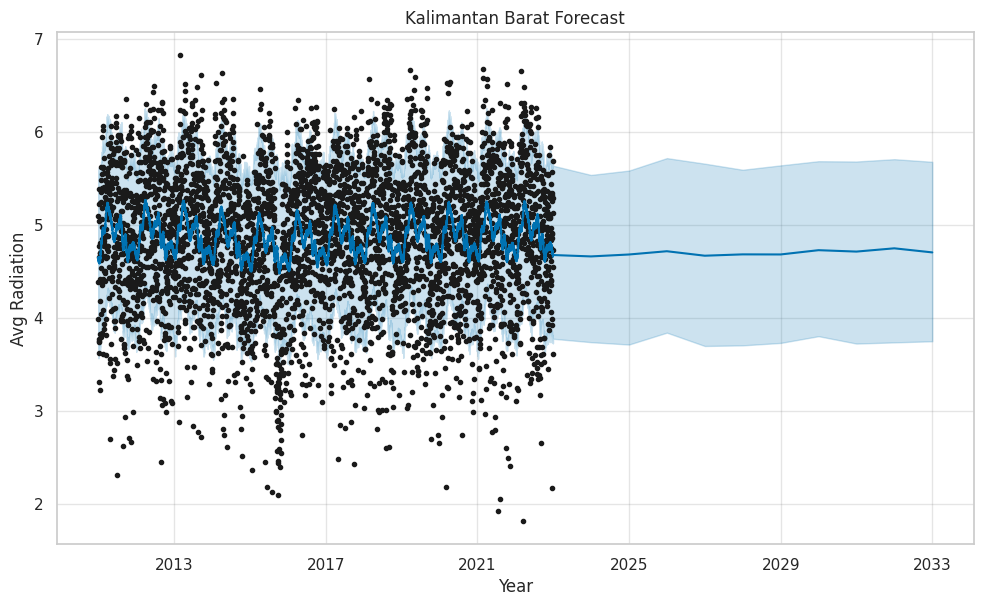

Error Metrics:
         Metric      Value
0           MAE   0.582439
1           MSE   0.539220
2          RMSE   0.734316
3  Accuracy (%)  86.870643


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/n2cu_vx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/cfz7s0px.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54307', 'data', 'file=/tmp/tmpfw5lgztm/n2cu_vx5.json', 'init=/tmp/tmpfw5lgztm/cfz7s0px.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_model0bs1q7pa/prophet_model-20241019034320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:43:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

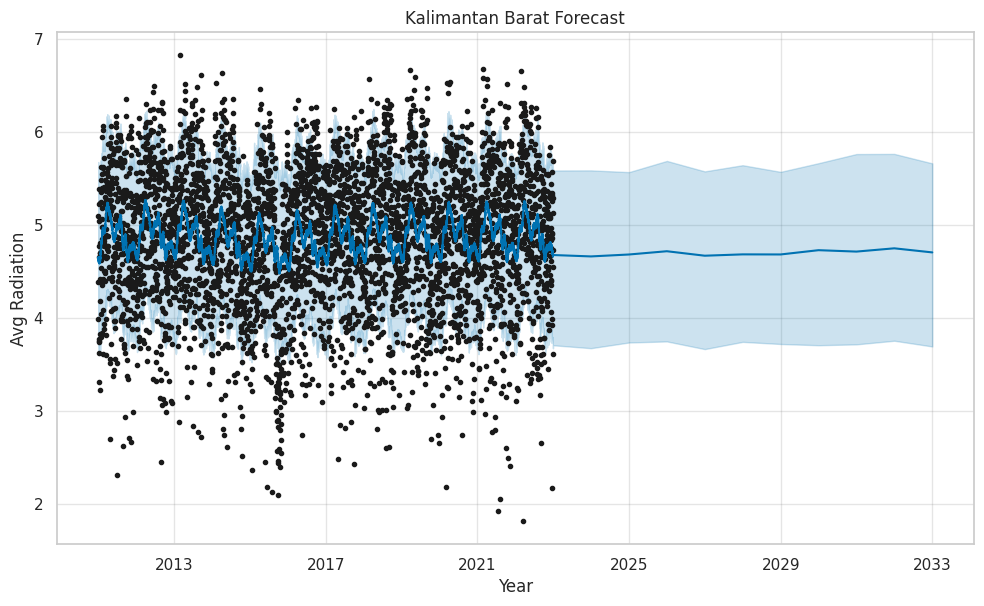

Error Metrics:
         Metric      Value
0           MAE   0.582439
1           MSE   0.539220
2          RMSE   0.734316
3  Accuracy (%)  86.870643


In [ ]:
# Prepare the data for Prophet
kalbar_rad = kalbar.reset_index()[['Date', 'Avg_Radiation']] # Reset the index to make 'Date' a column
kalbar_rad = kalbar_rad.rename(columns={'Date': 'ds', 'Avg_Radiation': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(kalbar_rad)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
kalbar_rad_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = kalbar_rad['y'].values
predicted = kalbar_rad_forecast['yhat'][:len(kalbar_rad)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(kalbar_rad_forecast)
plt.title("Kalimantan Barat Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Radiation")
plt.show()

# Display forecasted results
forecast_results = kalbar_rad_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

Prediksi data temperatur kalbar

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/9w043mc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/775tv4mw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79640', 'data', 'file=/tmp/tmpfw5lgztm/9w043mc_.json', 'init=/tmp/tmpfw5lgztm/775tv4mw.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelyr34drkc/prophet_model-20241019033402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

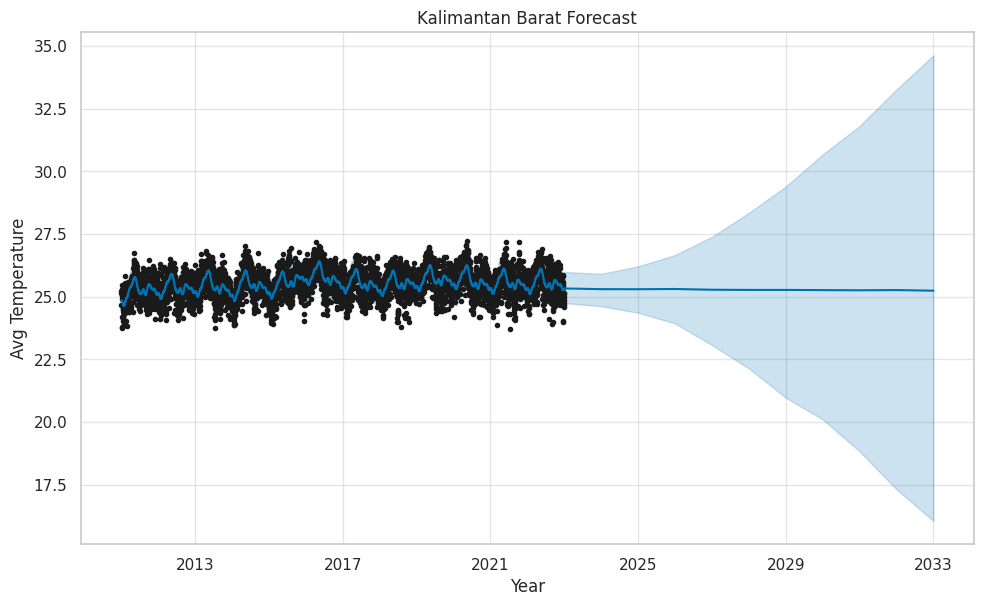

Error Metrics:
         Metric      Value
0           MAE   0.380936
1           MSE   0.226347
2          RMSE   0.475759
3  Accuracy (%)  98.502871


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/ve9bhf8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/xm7vmblu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23107', 'data', 'file=/tmp/tmpfw5lgztm/ve9bhf8e.json', 'init=/tmp/tmpfw5lgztm/xm7vmblu.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelrtn9evzh/prophet_model-20241019034326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:43:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

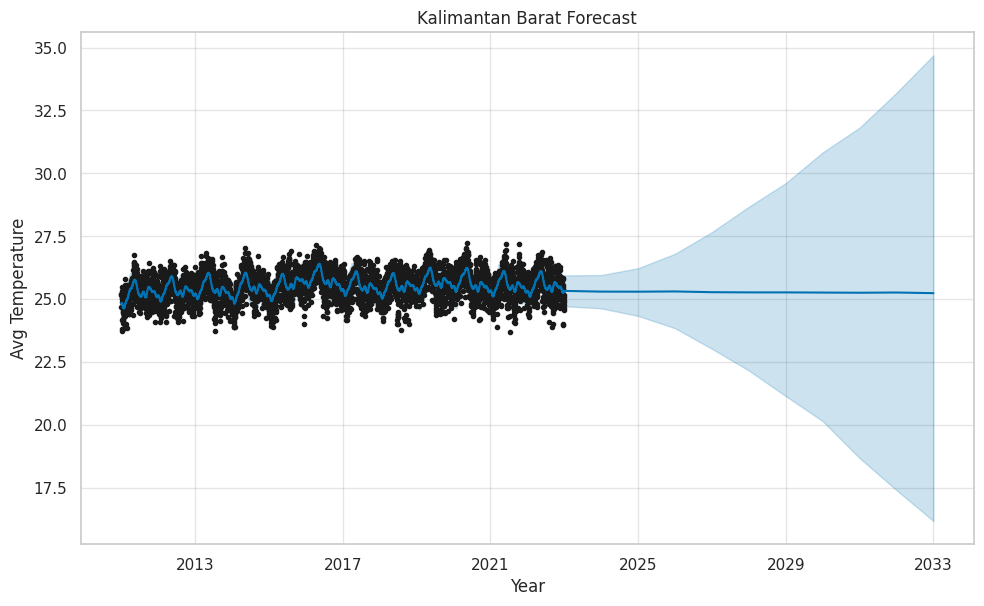

Error Metrics:
         Metric      Value
0           MAE   0.380936
1           MSE   0.226347
2          RMSE   0.475759
3  Accuracy (%)  98.502871


In [ ]:
# Prepare the data for Prophet
kalbar_temp = kalbar.reset_index()[['Date', 'Avg_Temperature']] # Reset the index to make 'Date' a column
kalbar_temp = kalbar_temp.rename(columns={'Date': 'ds', 'Avg_Temperature': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(kalbar_temp)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
kalbar_temp_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = kalbar_temp['y'].values
predicted = kalbar_temp_forecast['yhat'][:len(kalbar_temp)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(kalbar_temp_forecast)
plt.title("Kalimantan Barat Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Temperature")
plt.show()

# Display forecasted results
forecast_results = kalbar_temp_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

### Maluku

In [ ]:
maluku

Year  Month  Day  Avg_Radiation  Avg_Temperature
Date                                                        
2011-01-01  2011      1    1         2.9630         26.66175
2011-01-02  2011      1    2         4.7310         27.33175
2011-01-03  2011      1    3         5.7855         27.69375
2011-01-04  2011      1    4         6.5690         27.79350
2011-01-05  2011      1    5         6.6375         28.14550
...          ...    ...  ...            ...              ...
2022-12-27  2022     12   27         3.5675         26.99075
2022-12-28  2022     12   28         3.7275         27.08275
2022-12-29  2022     12   29         5.2890         27.51375
2022-12-30  2022     12   30         3.9420         27.46400
2022-12-31  2022     12   31         2.7650         27.00425

[4383 rows x 5 columns]

Year  Month  Day  Avg_Radiation  Avg_Temperature
Date                                                        
2011-01-01  2011      1    1         2.9630         26.66175
2011-01-02  2011      1    2         4.7310         27.33175
2011-01-03  2011      1    3         5.7855         27.69375
2011-01-04  2011      1    4         6.5690         27.79350
2011-01-05  2011      1    5         6.6375         28.14550
...          ...    ...  ...            ...              ...
2022-12-27  2022     12   27         3.5675         26.99075
2022-12-28  2022     12   28         3.7275         27.08275
2022-12-29  2022     12   29         5.2890         27.51375
2022-12-30  2022     12   30         3.9420         27.46400
2022-12-31  2022     12   31         2.7650         27.00425

[4383 rows x 5 columns]

Prediksi data radiasi maluku

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/ujswq0rg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/n630_s5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99827', 'data', 'file=/tmp/tmpfw5lgztm/ujswq0rg.json', 'init=/tmp/tmpfw5lgztm/n630_s5n.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelg3aw3f9j/prophet_model-20241019033413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

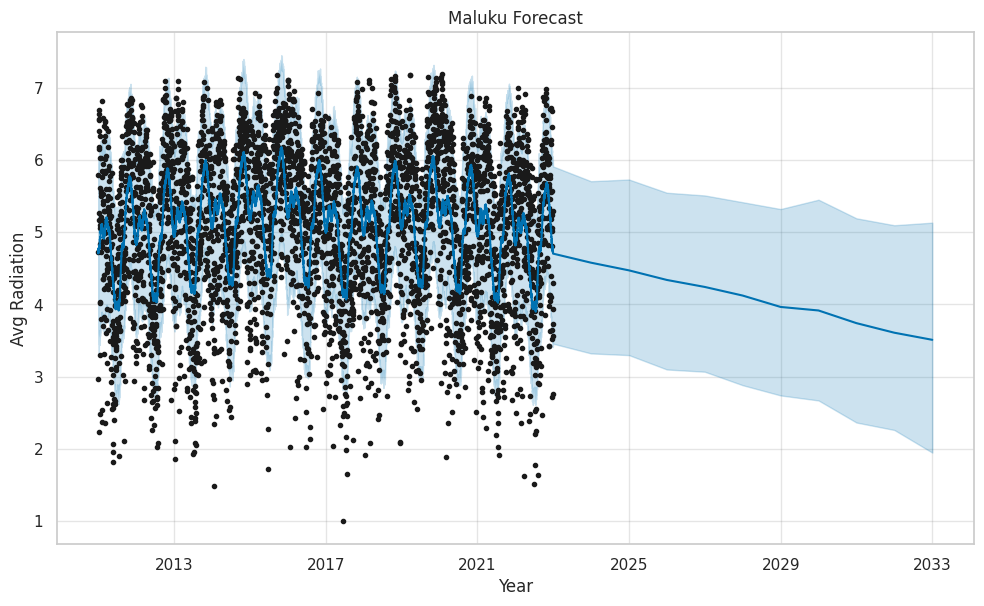

Error Metrics:
         Metric      Value
0           MAE   0.770939
1           MSE   0.918322
2          RMSE   0.958291
3  Accuracy (%)  82.238337


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/him_f9_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/zny8t0yw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75174', 'data', 'file=/tmp/tmpfw5lgztm/him_f9_8.json', 'init=/tmp/tmpfw5lgztm/zny8t0yw.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelgde21j86/prophet_model-20241019034338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:43:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

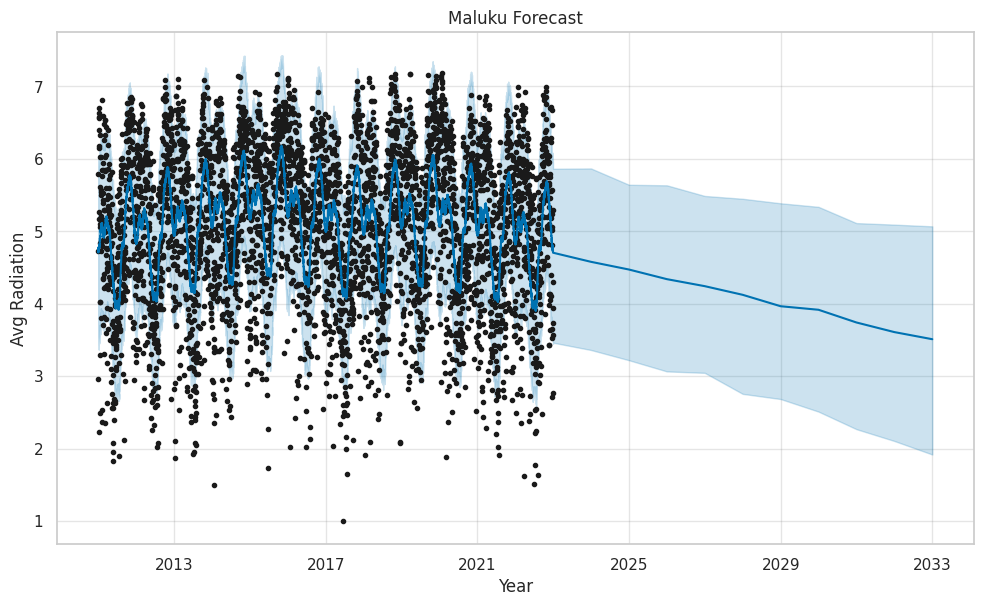

Error Metrics:
         Metric      Value
0           MAE   0.770939
1           MSE   0.918322
2          RMSE   0.958291
3  Accuracy (%)  82.238337


In [ ]:
# Prepare the data for Prophet
maluku_rad = maluku.reset_index()[['Date', 'Avg_Radiation']] # Reset the index to make 'Date' a column
maluku_rad = maluku_rad.rename(columns={'Date': 'ds', 'Avg_Radiation': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(maluku_rad)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
maluku_rad_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = maluku_rad['y'].values
predicted = maluku_rad_forecast['yhat'][:len(maluku_rad)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(maluku_rad_forecast)
plt.title("Maluku Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Radiation")
plt.show()

# Display forecasted results
forecast_results = maluku_rad_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

Prediksi data temperatur maluku

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/i7eb3wjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/v8rsdfo2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14099', 'data', 'file=/tmp/tmpfw5lgztm/i7eb3wjq.json', 'init=/tmp/tmpfw5lgztm/v8rsdfo2.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelwadhn1sa/prophet_model-20241019033422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

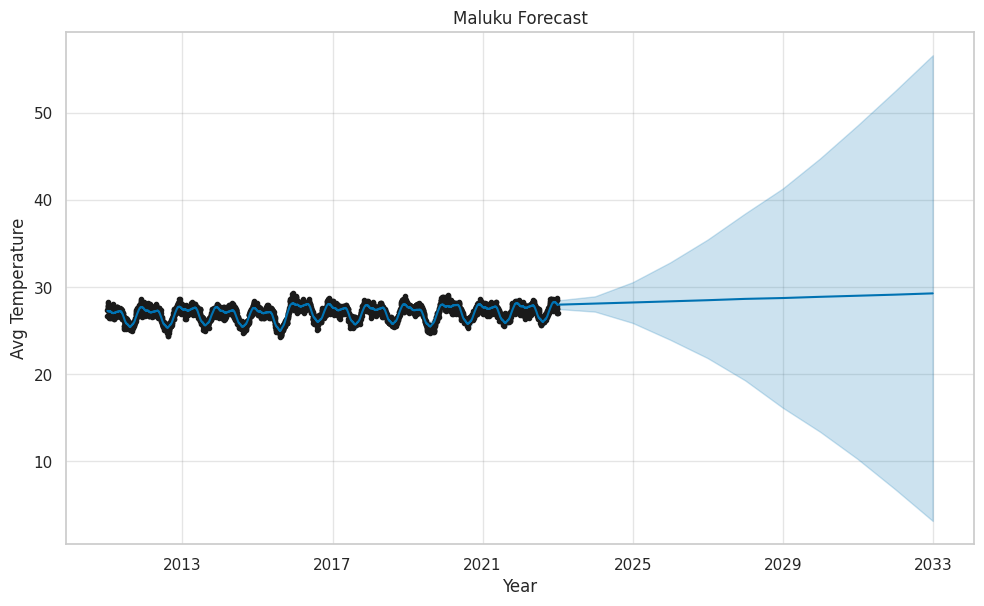

Error Metrics:
         Metric      Value
0           MAE   0.305014
1           MSE   0.145796
2          RMSE   0.381833
3  Accuracy (%)  98.872159


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/7jnekss8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/m55xjezu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26254', 'data', 'file=/tmp/tmpfw5lgztm/7jnekss8.json', 'init=/tmp/tmpfw5lgztm/m55xjezu.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modeluf_keiqu/prophet_model-20241019034346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:43:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

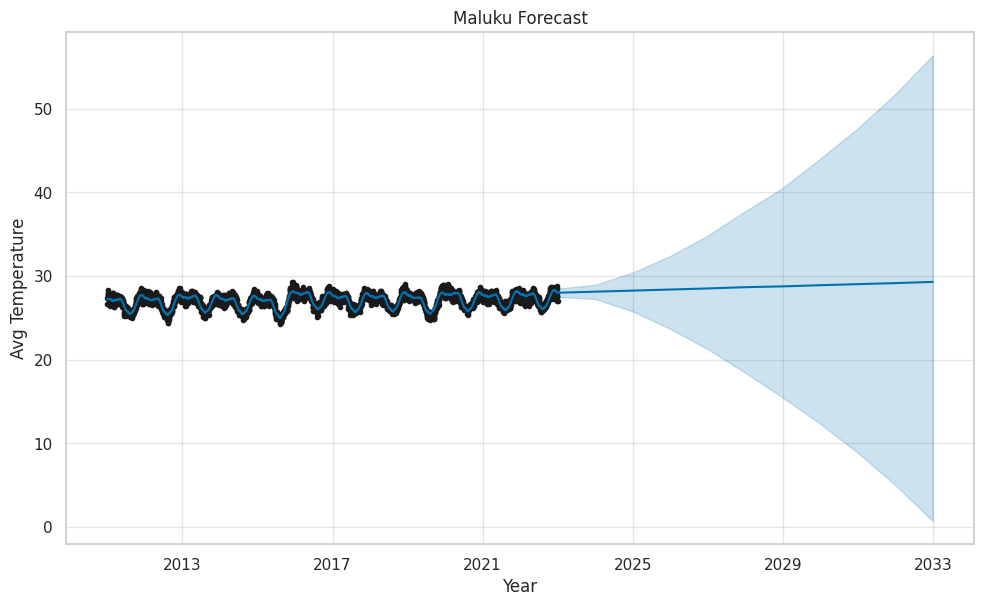

Error Metrics:
         Metric      Value
0           MAE   0.305014
1           MSE   0.145796
2          RMSE   0.381833
3  Accuracy (%)  98.872159


In [ ]:
# Prepare the data for Prophet
maluku_temp = maluku.reset_index()[['Date', 'Avg_Temperature']] # Reset the index to make 'Date' a column
maluku_temp = maluku_temp.rename(columns={'Date': 'ds', 'Avg_Temperature': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(maluku_temp)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
maluku_temp_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = maluku_temp['y'].values
predicted = maluku_temp_forecast['yhat'][:len(maluku_temp)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(maluku_temp_forecast)
plt.title("Maluku Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Temperature")
plt.show()

# Display forecasted results
forecast_results = maluku_temp_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

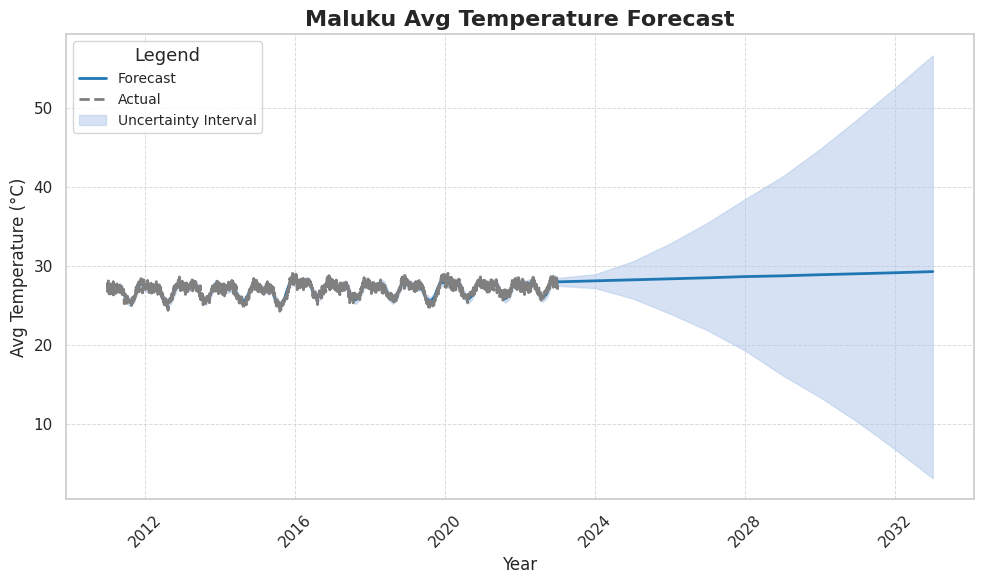

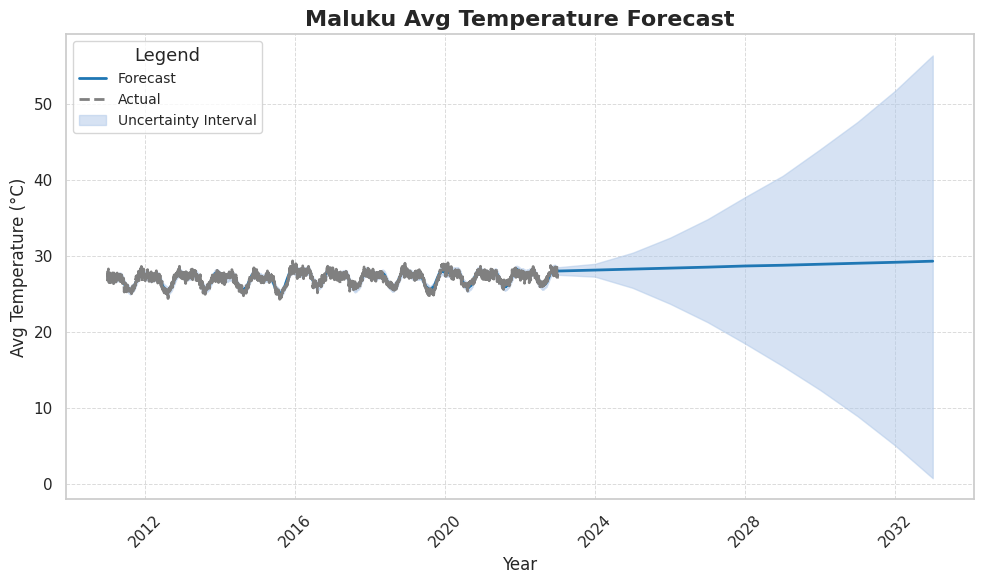

In [ ]:
# Import additional libraries for better visualization
import seaborn as sns

# Plot the forecast with enhanced styling
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size

# Plot the forecast (using seaborn for color palette consistency)
sns.lineplot(data=maluku_temp_forecast, x='ds', y='yhat', label='Forecast', color='#1f77b4', linewidth=2, ax=ax)
sns.lineplot(data=maluku_temp, x='ds', y='y', label='Actual', color='gray', linestyle='--', linewidth=2, ax=ax)

# Fill between the uncertainty bounds
ax.fill_between(maluku_temp_forecast['ds'],
                maluku_temp_forecast['yhat_lower'],
                maluku_temp_forecast['yhat_upper'],
                color='#aec7e8', alpha=0.5, label='Uncertainty Interval')

# Adding labels and title
ax.set_title('Maluku Avg Temperature Forecast', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Avg Temperature (°C)', fontsize=12)

# Adding a grid for easier reading of values
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Customize the legend for clarity
ax.legend(loc='upper left', fontsize=10, title='Legend', title_fontsize='13')

# Customize x-axis date formatting
plt.xticks(rotation=45)  # Rotate dates for better readability

# Show the plot
plt.tight_layout()  # Ensure everything fits well
plt.show()


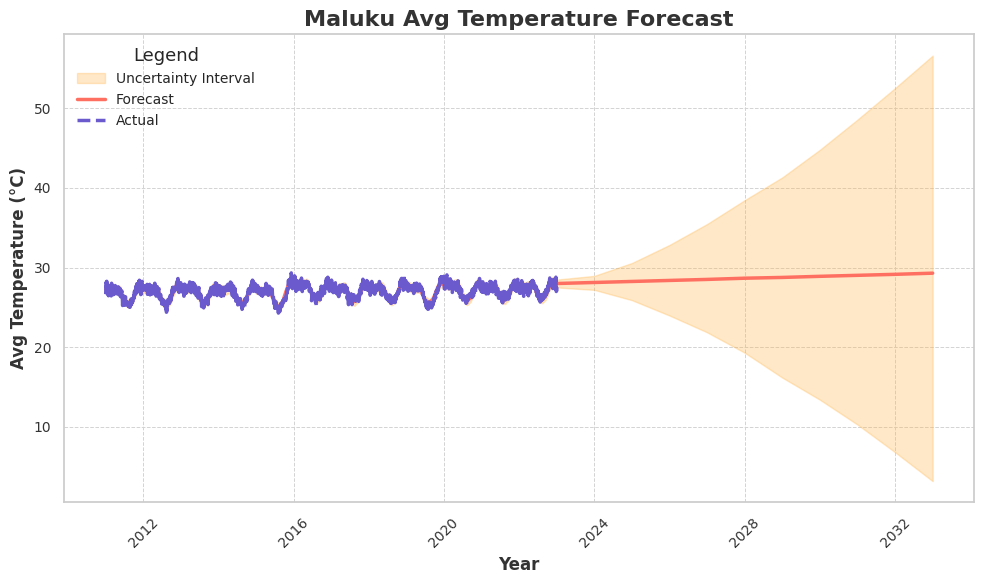

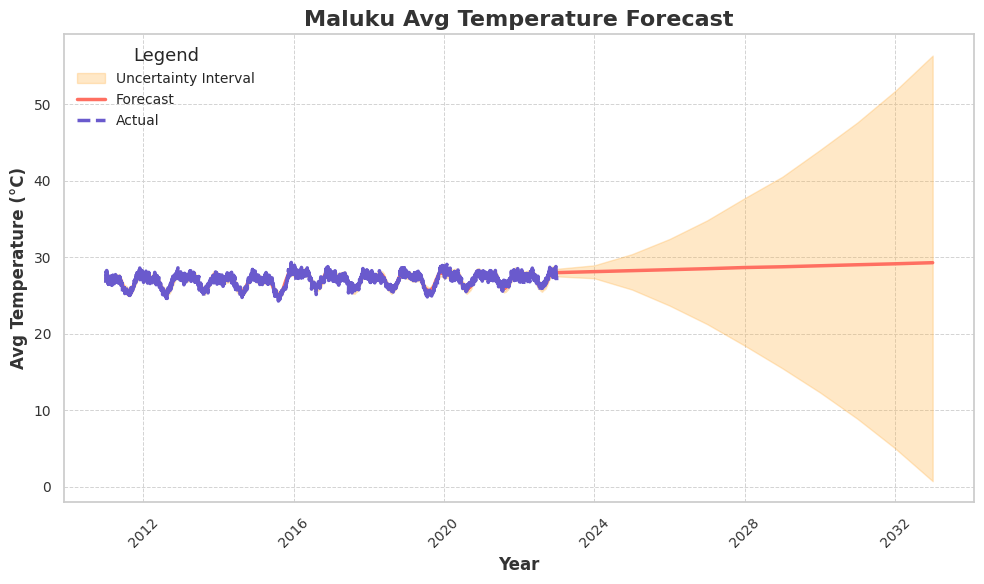

In [ ]:
# # Import additional libraries for better visualization
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Set a vibrant color palette
# forecast_color = '#FF6F61'  # A bold coral color for the forecast
# actual_color = '#6A5ACD'    # A rich, vibrant blue for the actual data
# uncertainty_color = '#FFB347'  # A warm orange for uncertainty intervals

# # Plot the forecast with enhanced styling
# fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size

# # Plot the forecast line with a vibrant color
# sns.lineplot(data=maluku_temp_forecast, x='ds', y='yhat', label='Forecast', color=forecast_color, linewidth=2.5, ax=ax)

# # Plot the actual historical data line in a contrasting color
# sns.lineplot(data=maluku_temp, x='ds', y='y', label='Actual', color=actual_color, linestyle='--', linewidth=2.5, ax=ax)

# # Fill between the uncertainty bounds with a warm color and transparency
# ax.fill_between(maluku_temp_forecast['ds'],
#                 maluku_temp_forecast['yhat_lower'],
#                 maluku_temp_forecast['yhat_upper'],
#                 color=uncertainty_color, alpha=0.3, label='Uncertainty Interval')

# # Adding labels and title with enhanced fonts
# ax.set_title('Maluku Avg Temperature Forecast', fontsize=16, fontweight='bold', color='#333333')
# ax.set_xlabel('Year', fontsize=12, fontweight='bold', color='#333333')
# ax.set_ylabel('Avg Temperature (°C)', fontsize=12, fontweight='bold', color='#333333')

# # Adding a grid for easier reading of values
# ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, color='#D3D3D3')

# # Customize the legend for clarity and aesthetic
# ax.legend(loc='upper left', fontsize=10, title='Legend', title_fontsize='13', frameon=False)

# # Customize x-axis date formatting
# plt.xticks(rotation=45, fontsize=10, color='#333333')  # Rotate dates for better readability
# plt.yticks(fontsize=10, color='#333333')

# # Show the plot with tight layout
# plt.tight_layout()  # Ensure everything fits well
# plt.show()


# Import additional libraries for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set a vibrant color palette
forecast_color = '#FF6F61'  # A bold coral color for the forecast
actual_color = '#6A5ACD'    # A rich, vibrant blue for the actual data
uncertainty_color = '#FFB347'  # A warm orange for uncertainty intervals

# Plot the forecast with enhanced styling
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size

# Plot the uncertainty bounds first to ensure the forecast and actual lines are on top
ax.fill_between(maluku_temp_forecast['ds'],
                maluku_temp_forecast['yhat_lower'],
                maluku_temp_forecast['yhat_upper'],
                color=uncertainty_color, alpha=0.3, label='Uncertainty Interval')

# Plot the forecast line with a vibrant color (on top of the uncertainty region)
sns.lineplot(data=maluku_temp_forecast, x='ds', y='yhat', label='Forecast', color=forecast_color, linewidth=2.5, ax=ax)

# Plot the actual historical data line in a contrasting color (on top of the uncertainty region)
sns.lineplot(data=maluku_temp, x='ds', y='y', label='Actual', color=actual_color, linestyle='--', linewidth=2.5, ax=ax)

# Adding labels and title with enhanced fonts
ax.set_title('Maluku Avg Temperature Forecast', fontsize=16, fontweight='bold', color='#333333')
ax.set_xlabel('Year', fontsize=12, fontweight='bold', color='#333333')
ax.set_ylabel('Avg Temperature (°C)', fontsize=12, fontweight='bold', color='#333333')

# Adding a grid for easier reading of values
ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=1, color='#D3D3D3')

# Customize the legend for clarity and aesthetic
ax.legend(loc='upper left', fontsize=10, title='Legend', title_fontsize='13', frameon=False)

# Customize x-axis date formatting
plt.xticks(rotation=45, fontsize=10, color='#333333')  # Rotate dates for better readability
plt.yticks(fontsize=10, color='#333333')

# Show the plot with tight layout
plt.tight_layout()  # Ensure everything fits well
plt.show()


### Sumatera Utara

Prediksi data radiasi sumut

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/_b_kfb7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/thr88mo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7425', 'data', 'file=/tmp/tmpfw5lgztm/_b_kfb7e.json', 'init=/tmp/tmpfw5lgztm/thr88mo_.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modela13kepaf/prophet_model-20241019033430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a

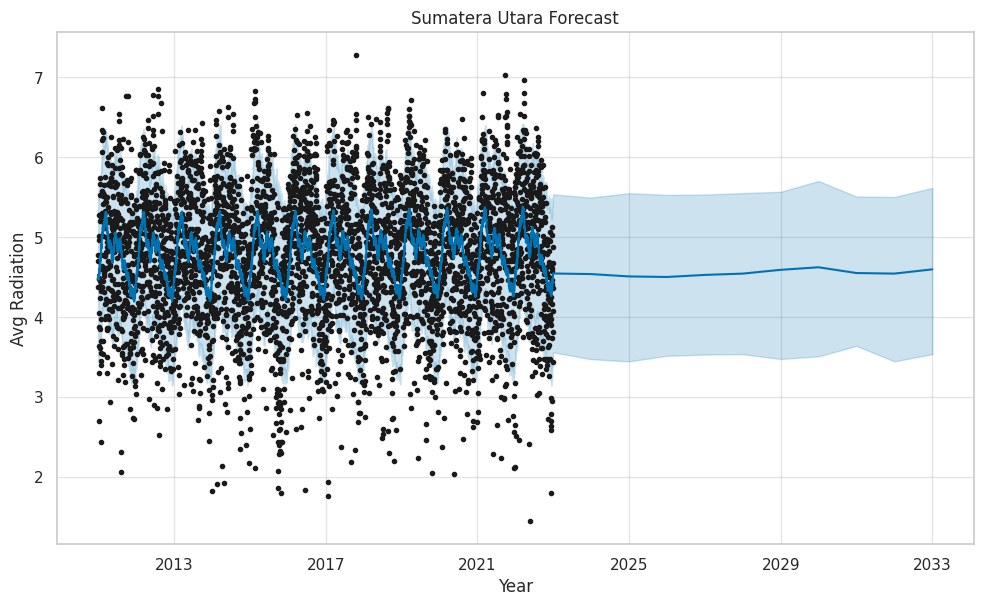

Error Metrics:
         Metric      Value
0           MAE   0.629394
1           MSE   0.639102
2          RMSE   0.799438
3  Accuracy (%)  85.305717


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/fyeqe3rt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/3amizf0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86075', 'data', 'file=/tmp/tmpfw5lgztm/fyeqe3rt.json', 'init=/tmp/tmpfw5lgztm/3amizf0d.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_model1sd94xd9/prophet_model-20241019034353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:43:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

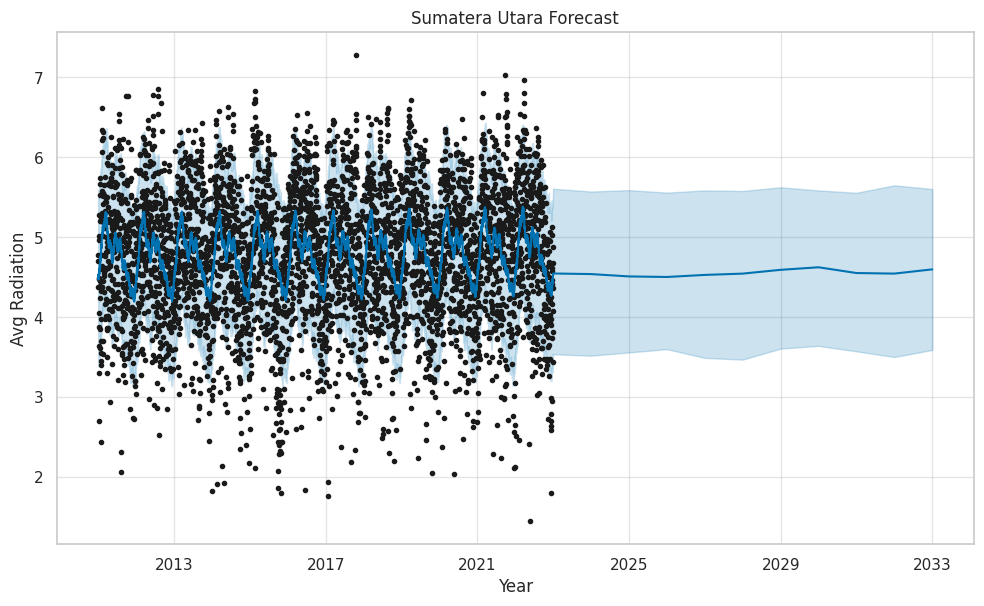

Error Metrics:
         Metric      Value
0           MAE   0.629394
1           MSE   0.639102
2          RMSE   0.799438
3  Accuracy (%)  85.305717


In [ ]:
# Prepare the data for Prophet
sumut_rad = sumut.reset_index()[['Date', 'Avg_Radiation']] # Reset the index to make 'Date' a column
sumut_rad = sumut_rad.rename(columns={'Date': 'ds', 'Avg_Radiation': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(sumut_rad)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
sumut_rad_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = sumut_rad['y'].values
predicted = sumut_rad_forecast['yhat'][:len(sumut_rad)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(sumut_rad_forecast)
plt.title("Sumatera Utara Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Radiation")
plt.show()

# Display forecasted results
forecast_results = sumut_rad_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

Prediksi data temp sumut

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/lozapgr0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/l0vudaaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62927', 'data', 'file=/tmp/tmpfw5lgztm/lozapgr0.json', 'init=/tmp/tmpfw5lgztm/l0vudaaq.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelxr53jx1g/prophet_model-20241019033432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

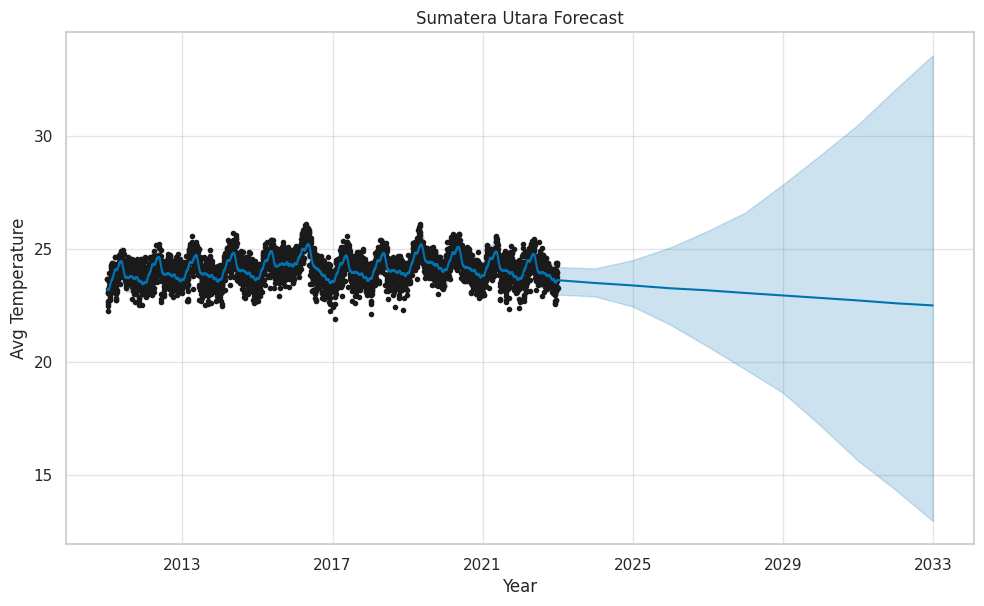

Error Metrics:
         Metric      Value
0           MAE   0.368495
1           MSE   0.212231
2          RMSE   0.460685
3  Accuracy (%)  98.467380


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/wj60u967.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/pw_zln1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64846', 'data', 'file=/tmp/tmpfw5lgztm/wj60u967.json', 'init=/tmp/tmpfw5lgztm/pw_zln1v.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelznj5hqgi/prophet_model-20241019034357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:43:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:43:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

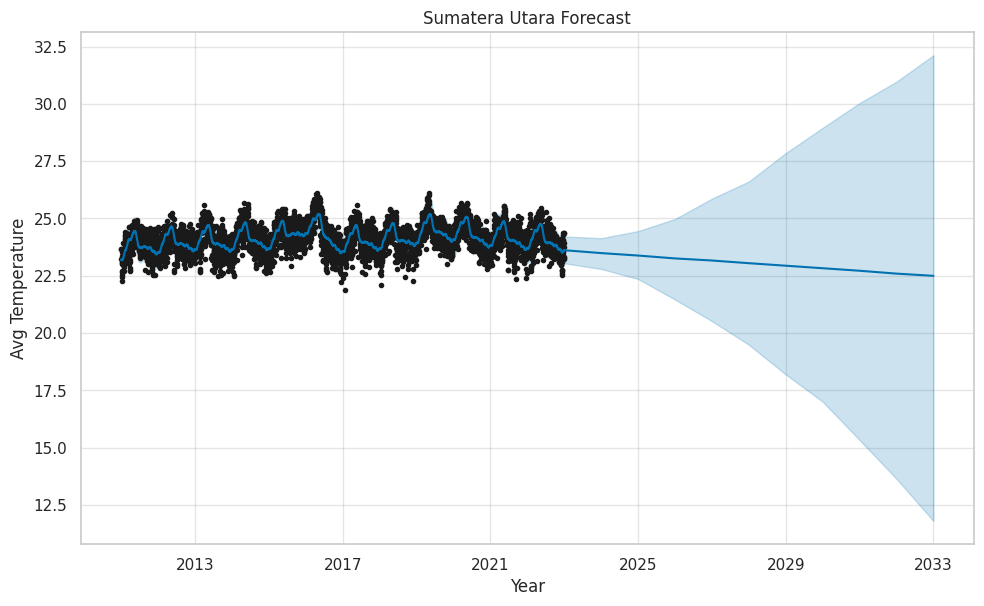

Error Metrics:
         Metric      Value
0           MAE   0.368495
1           MSE   0.212231
2          RMSE   0.460685
3  Accuracy (%)  98.467380


In [ ]:
# Prepare the data for Prophet
sumut_temp = sumut.reset_index()[['Date', 'Avg_Temperature']] # Reset the index to make 'Date' a column
sumut_temp = sumut_temp.rename(columns={'Date': 'ds', 'Avg_Temperature': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(sumut_temp)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
sumut_temp_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = sumut_temp['y'].values
predicted = sumut_temp_forecast['yhat'][:len(sumut_temp)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(sumut_temp_forecast)
plt.title("Sumatera Utara Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Temperature")
plt.show()

# Display forecasted results
forecast_results = sumut_temp_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

### NTT

Prediksi data radiasi ntt

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/bkoqmmf8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/eaqnm70h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74478', 'data', 'file=/tmp/tmpfw5lgztm/bkoqmmf8.json', 'init=/tmp/tmpfw5lgztm/eaqnm70h.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_model9sj9bgbw/prophet_model-20241019033437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

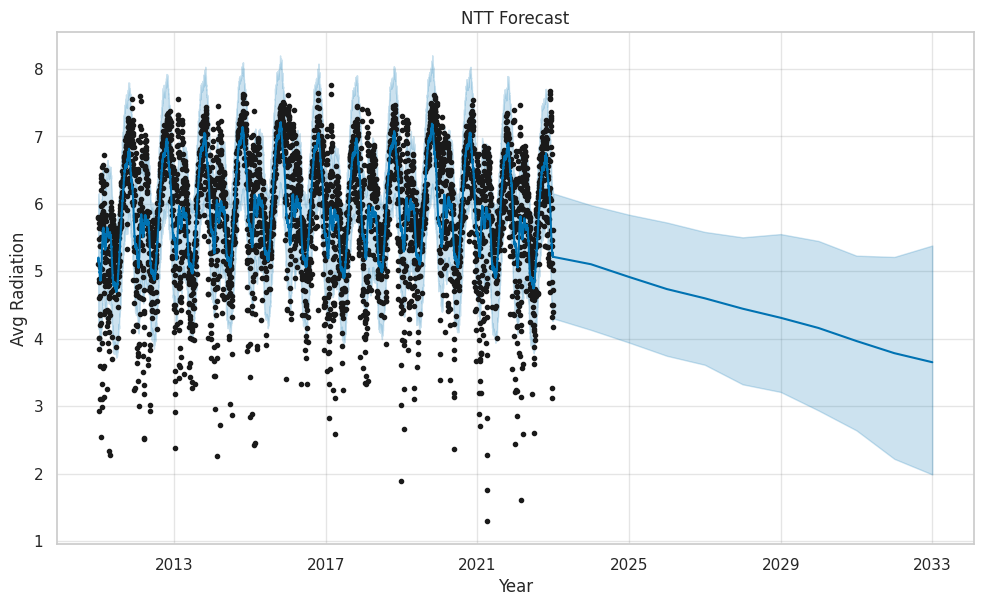

Error Metrics:
         Metric      Value
0           MAE   0.527990
1           MSE   0.542966
2          RMSE   0.736863
3  Accuracy (%)  89.558135


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/lnvafugc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/ccsp5biz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9684', 'data', 'file=/tmp/tmpfw5lgztm/lnvafugc.json', 'init=/tmp/tmpfw5lgztm/ccsp5biz.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelfxkavkrq/prophet_model-20241019034400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:44:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:44:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a

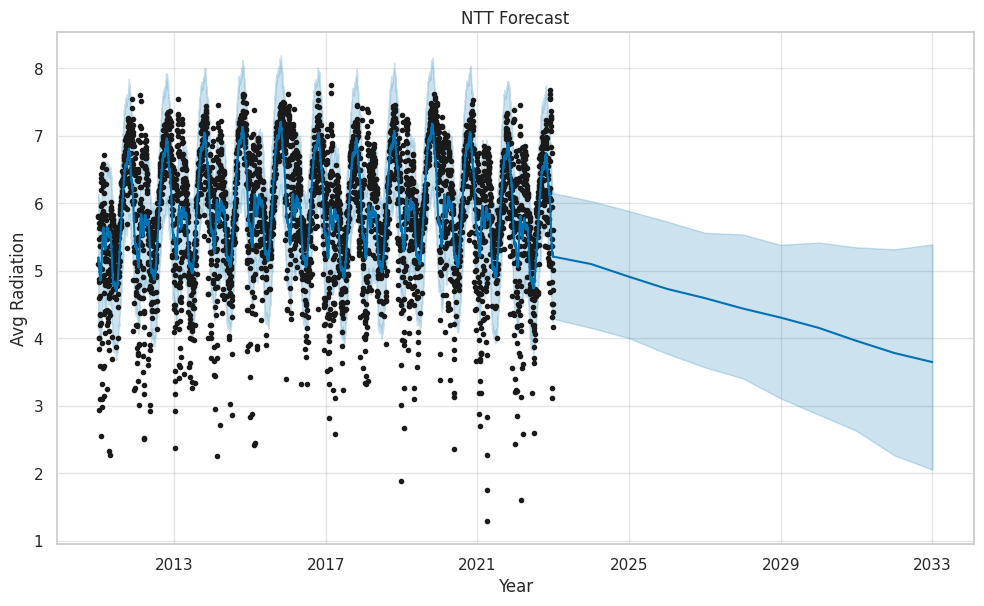

Error Metrics:
         Metric      Value
0           MAE   0.527990
1           MSE   0.542966
2          RMSE   0.736863
3  Accuracy (%)  89.558135


In [ ]:
# Prepare the data for Prophet
ntt_rad = ntt.reset_index()[['Date', 'Avg_Radiation']] # Reset the index to make 'Date' a column
ntt_rad = ntt_rad.rename(columns={'Date': 'ds', 'Avg_Radiation': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(ntt_rad)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
ntt_rad_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = ntt_rad['y'].values
predicted = ntt_rad_forecast['yhat'][:len(ntt_rad)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(ntt_rad_forecast)
plt.title("NTT Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Radiation")
plt.show()

# Display forecasted results
forecast_results = ntt_rad_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

Prediksi data temp ntt

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/73f2o3c2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/14xsvsxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79127', 'data', 'file=/tmp/tmpfw5lgztm/73f2o3c2.json', 'init=/tmp/tmpfw5lgztm/14xsvsxs.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_modelk29ij5v4/prophet_model-20241019033440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:34:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:34:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

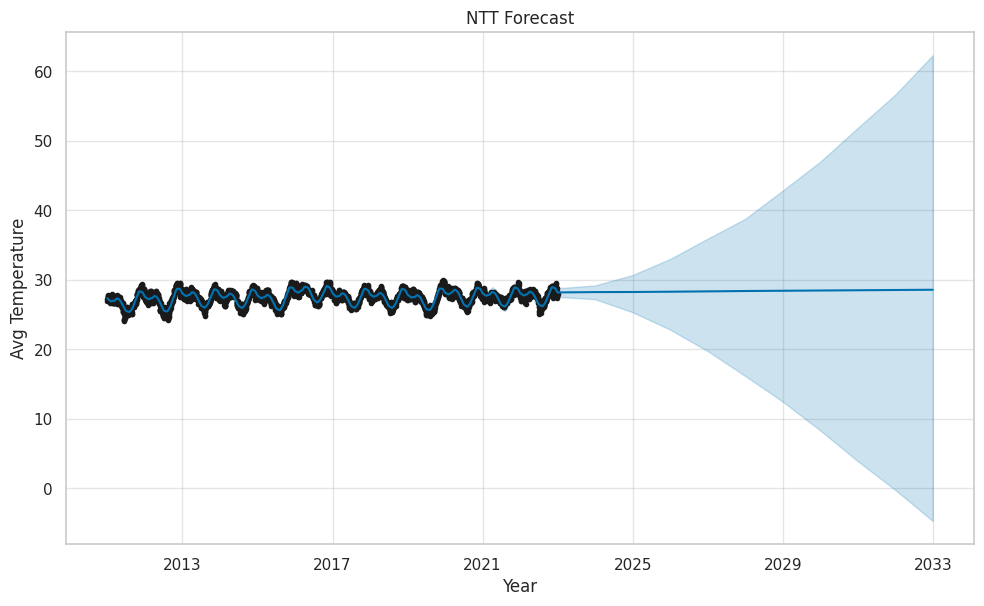

Error Metrics:
         Metric      Value
0           MAE   0.360545
1           MSE   0.203335
2          RMSE   0.450926
3  Accuracy (%)  98.685356


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/_vpsbnlb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfw5lgztm/9f14lhz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81574', 'data', 'file=/tmp/tmpfw5lgztm/_vpsbnlb.json', 'init=/tmp/tmpfw5lgztm/9f14lhz_.json', 'output', 'file=/tmp/tmpfw5lgztm/prophet_model9qp1lc19/prophet_model-20241019034403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:44:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:44:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in 

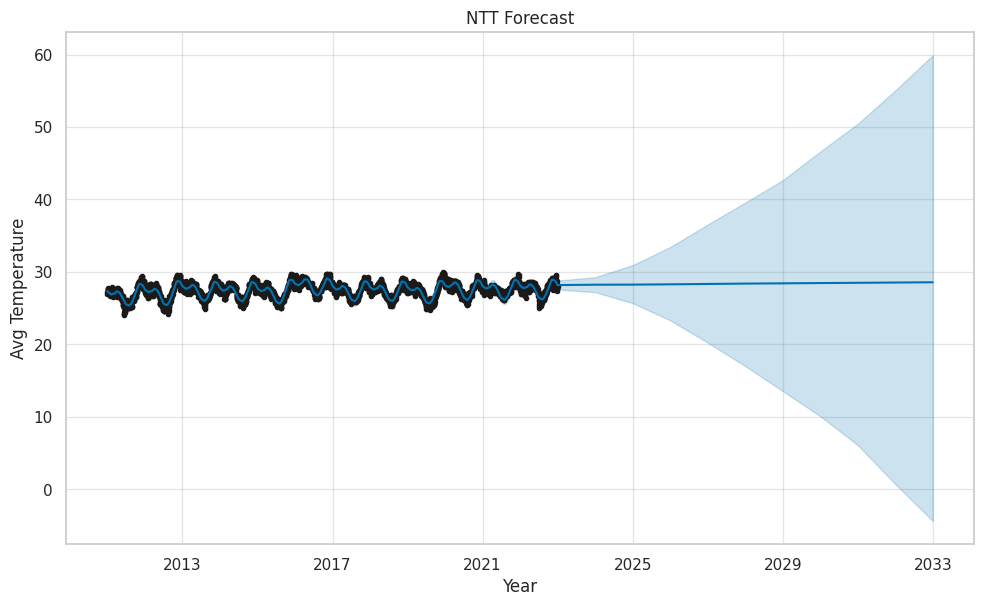

Error Metrics:
         Metric      Value
0           MAE   0.360545
1           MSE   0.203335
2          RMSE   0.450926
3  Accuracy (%)  98.685356


In [ ]:
# Prepare the data for Prophet
ntt_temp = ntt.reset_index()[['Date', 'Avg_Temperature']] # Reset the index to make 'Date' a column
ntt_temp = ntt_temp.rename(columns={'Date': 'ds', 'Avg_Temperature': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(ntt_temp)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=10, freq='Y') # Forecast for one year

# Make predictions
ntt_temp_forecast = model.predict(future)

# Compare actuals and forecast for the historical period
actual = ntt_temp['y'].values
predicted = ntt_temp_forecast['yhat'][:len(ntt_temp)].values

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
accuracy = 100 - np.mean(np.abs((actual - predicted) / actual)) * 100

# Plot the forecast
model.plot(ntt_temp_forecast)
plt.title("NTT Forecast")
plt.xlabel("Year")
plt.ylabel("Avg Temperature")
plt.show()

# Display forecasted results
forecast_results = ntt_temp_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Display the error metrics and the forecast table
error_metrics = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'Accuracy (%)'],
    'Value': [mae, mse, rmse, accuracy]
})

print("Error Metrics:")
print(error_metrics)

# Suhu Modul Surya

## Papua

In [ ]:
future_papua

Avg_Radiation  Avg_Temperature
2023-01-31       4.743249        26.570333
2023-02-28       4.779650        26.560349
2023-03-31       4.791725        26.558880
2023-04-30       4.797089        26.561592
2023-05-31       4.799944        26.565693
...                   ...              ...
2030-08-31       4.890187        26.758251
2030-09-30       4.889941        26.758728
2030-10-31       4.889698        26.759178
2030-11-30       4.889455        26.759605
2030-12-31       4.889216        26.760008

[96 rows x 2 columns]

Avg_Radiation  Avg_Temperature
2023-01-31       4.748224        26.494980
2023-02-28       4.776966        26.465914
2023-03-31       4.776191        26.438047
2023-04-30       4.768148        26.412069
2023-05-31       4.759562        26.387962
...                   ...              ...
2030-08-31       4.611818        25.450647
2030-09-30       4.609647        25.442595
2030-10-31       4.607473        25.434542
2030-11-30       4.605294        25.426489
2030-12-31       4.603111        25.418438

[96 rows x 2 columns]

In [ ]:
future_papua['Tsel_surya'] = future_papua['Avg_Temperature'] + ((0.32/(8.91+(2*4)))*future_papua['Avg_Radiation'])
future_papua

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.743249        26.570333   26.660093
2023-02-28       4.779650        26.560349   26.650797
2023-03-31       4.791725        26.558880   26.649557
2023-04-30       4.797089        26.561592   26.652370
2023-05-31       4.799944        26.565693   26.656527
...                   ...              ...         ...
2030-08-31       4.890187        26.758251   26.850792
2030-09-30       4.889941        26.758728   26.851263
2030-10-31       4.889698        26.759178   26.851709
2030-11-30       4.889455        26.759605   26.852133
2030-12-31       4.889216        26.760008   26.852530

[96 rows x 3 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.748224        26.494980   26.584833
2023-02-28       4.776966        26.465914   26.556313
2023-03-31       4.776191        26.438047   26.528431
2023-04-30       4.768148        26.412069   26.502300
2023-05-31       4.759562        26.387962   26.478031
...                   ...              ...         ...
2030-08-31       4.611818        25.450647   25.537920
2030-09-30       4.609647        25.442595   25.529827
2030-10-31       4.607473        25.434542   25.521732
2030-11-30       4.605294        25.426489   25.513638
2030-12-31       4.603111        25.418438   25.505547

[96 rows x 3 columns]

In [ ]:
future_papua['Apakah di atas 25?'] = future_papua['Tsel_surya'] >= 25
future_papua

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.743249        26.570333   26.660093                True
2023-02-28       4.779650        26.560349   26.650797                True
2023-03-31       4.791725        26.558880   26.649557                True
2023-04-30       4.797089        26.561592   26.652370                True
2023-05-31       4.799944        26.565693   26.656527                True
...                   ...              ...         ...                 ...
2030-08-31       4.890187        26.758251   26.850792                True
2030-09-30       4.889941        26.758728   26.851263                True
2030-10-31       4.889698        26.759178   26.851709                True
2030-11-30       4.889455        26.759605   26.852133                True
2030-12-31       4.889216        26.760008   26.852530                True

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.748224        26.494980   26.584833                True
2023-02-28       4.776966        26.465914   26.556313                True
2023-03-31       4.776191        26.438047   26.528431                True
2023-04-30       4.768148        26.412069   26.502300                True
2023-05-31       4.759562        26.387962   26.478031                True
...                   ...              ...         ...                 ...
2030-08-31       4.611818        25.450647   25.537920                True
2030-09-30       4.609647        25.442595   25.529827                True
2030-10-31       4.607473        25.434542   25.521732                True
2030-11-30       4.605294        25.426489   25.513638                True
2030-12-31       4.603111        25.418438   25.505547                True

[96 rows x 4 columns]

## Kalbar

In [ ]:
future_kalbar

Avg_Radiation  Avg_Temperature
2023-01-31       4.810549        24.967167
2023-02-28       4.825552        25.023352
2023-03-31       4.826391        25.053474
2023-04-30       4.822848        25.070183
2023-05-31       4.817371        25.080057
...                   ...              ...
2030-08-31       4.759738        25.201548
2030-09-30       4.759706        25.201723
2030-10-31       4.759676        25.201893
2030-11-30       4.759646        25.202055
2030-12-31       4.759617        25.202211

[96 rows x 2 columns]

Avg_Radiation  Avg_Temperature
2023-01-31       4.969176        25.021742
2023-02-28       4.984263        25.124483
2023-03-31       4.998727        25.177664
2023-04-30       5.010891        25.214725
2023-05-31       5.019513        25.242565
...                   ...              ...
2030-08-31       5.065080        25.541458
2030-09-30       5.065087        25.541563
2030-10-31       5.065094        25.541662
2030-11-30       5.065101        25.541756
2030-12-31       5.065107        25.541845

[96 rows x 2 columns]

In [ ]:
future_kalbar['Tsel_surya'] = future_kalbar['Avg_Temperature'] + ((0.32/(8.91+(2*4)))*future_kalbar['Avg_Radiation'])
future_kalbar

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.810549        24.967167   25.058201
2023-02-28       4.825552        25.023352   25.114670
2023-03-31       4.826391        25.053474   25.144808
2023-04-30       4.822848        25.070183   25.161449
2023-05-31       4.817371        25.080057   25.171219
...                   ...              ...         ...
2030-08-31       4.759738        25.201548   25.291620
2030-09-30       4.759706        25.201723   25.291794
2030-10-31       4.759676        25.201893   25.291964
2030-11-30       4.759646        25.202055   25.292126
2030-12-31       4.759617        25.202211   25.292280

[96 rows x 3 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.969176        25.021742   25.115778
2023-02-28       4.984263        25.124483   25.218803
2023-03-31       4.998727        25.177664   25.272259
2023-04-30       5.010891        25.214725   25.309549
2023-05-31       5.019513        25.242565   25.337553
...                   ...              ...         ...
2030-08-31       5.065080        25.541458   25.637308
2030-09-30       5.065087        25.541563   25.637413
2030-10-31       5.065094        25.541662   25.637512
2030-11-30       5.065101        25.541756   25.637606
2030-12-31       5.065107        25.541845   25.637695

[96 rows x 3 columns]

In [ ]:
future_kalbar['Apakah di atas 25?'] = future_kalbar['Tsel_surya'] >= 25
future_kalbar

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.810549        24.967167   25.058201                True
2023-02-28       4.825552        25.023352   25.114670                True
2023-03-31       4.826391        25.053474   25.144808                True
2023-04-30       4.822848        25.070183   25.161449                True
2023-05-31       4.817371        25.080057   25.171219                True
...                   ...              ...         ...                 ...
2030-08-31       4.759738        25.201548   25.291620                True
2030-09-30       4.759706        25.201723   25.291794                True
2030-10-31       4.759676        25.201893   25.291964                True
2030-11-30       4.759646        25.202055   25.292126                True
2030-12-31       4.759617        25.202211   25.292280                True

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.969176        25.021742   25.115778                True
2023-02-28       4.984263        25.124483   25.218803                True
2023-03-31       4.998727        25.177664   25.272259                True
2023-04-30       5.010891        25.214725   25.309549                True
2023-05-31       5.019513        25.242565   25.337553                True
...                   ...              ...         ...                 ...
2030-08-31       5.065080        25.541458   25.637308                True
2030-09-30       5.065087        25.541563   25.637413                True
2030-10-31       5.065094        25.541662   25.637512                True
2030-11-30       5.065101        25.541756   25.637606                True
2030-12-31       5.065107        25.541845   25.637695                True

[96 rows x 4 columns]

## Maluku

In [ ]:
future_maluku

Avg_Radiation  Avg_Temperature
2023-01-31       4.515848        27.426922
2023-02-28       4.623744        27.460880
2023-03-31       4.676573        27.465883
2023-04-30       4.714456        27.468649
2023-05-31       4.741622        27.469589
...                   ...              ...
2030-08-31       4.936567        27.401575
2030-09-30       4.936944        27.402275
2030-10-31       4.937313        27.402969
2030-11-30       4.937669        27.403650
2030-12-31       4.938016        27.404322

[96 rows x 2 columns]

Avg_Radiation  Avg_Temperature
2023-01-31       4.632887        27.577509
2023-02-28       4.774059        27.643763
2023-03-31       4.862916        27.684439
2023-04-30       4.924632        27.717033
2023-05-31       4.966874        27.743181
...                   ...              ...
2030-08-31       5.417984        28.504122
2030-09-30       5.418433        28.505823
2030-10-31       5.418863        28.507458
2030-11-30       5.419274        28.509027
2030-12-31       5.419669        28.510536

[96 rows x 2 columns]

In [ ]:
future_maluku['Tsel_surya'] = future_maluku['Avg_Temperature'] + ((0.32/(8.91+(2*4)))*future_maluku['Avg_Radiation'])
future_maluku

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.515848        27.426922   27.512379
2023-02-28       4.623744        27.460880   27.548378
2023-03-31       4.676573        27.465883   27.554382
2023-04-30       4.714456        27.468649   27.557863
2023-05-31       4.741622        27.469589   27.559319
...                   ...              ...         ...
2030-08-31       4.936567        27.401575   27.494993
2030-09-30       4.936944        27.402275   27.495701
2030-10-31       4.937313        27.402969   27.496401
2030-11-30       4.937669        27.403650   27.497089
2030-12-31       4.938016        27.404322   27.497766

[96 rows x 3 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.632887        27.577509   27.665180
2023-02-28       4.774059        27.643763   27.734106
2023-03-31       4.862916        27.684439   27.776463
2023-04-30       4.924632        27.717033   27.810226
2023-05-31       4.966874        27.743181   27.837173
...                   ...              ...         ...
2030-08-31       5.417984        28.504122   28.606649
2030-09-30       5.418433        28.505823   28.608360
2030-10-31       5.418863        28.507458   28.610003
2030-11-30       5.419274        28.509027   28.611580
2030-12-31       5.419669        28.510536   28.613096

[96 rows x 3 columns]

In [ ]:
future_maluku['Apakah di atas 25?'] = future_maluku['Tsel_surya'] >= 25
future_maluku

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.515848        27.426922   27.512379                True
2023-02-28       4.623744        27.460880   27.548378                True
2023-03-31       4.676573        27.465883   27.554382                True
2023-04-30       4.714456        27.468649   27.557863                True
2023-05-31       4.741622        27.469589   27.559319                True
...                   ...              ...         ...                 ...
2030-08-31       4.936567        27.401575   27.494993                True
2030-09-30       4.936944        27.402275   27.495701                True
2030-10-31       4.937313        27.402969   27.496401                True
2030-11-30       4.937669        27.403650   27.497089                True
2030-12-31       4.938016        27.404322   27.497766                True

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.632887        27.577509   27.665180                True
2023-02-28       4.774059        27.643763   27.734106                True
2023-03-31       4.862916        27.684439   27.776463                True
2023-04-30       4.924632        27.717033   27.810226                True
2023-05-31       4.966874        27.743181   27.837173                True
...                   ...              ...         ...                 ...
2030-08-31       5.417984        28.504122   28.606649                True
2030-09-30       5.418433        28.505823   28.608360                True
2030-10-31       5.418863        28.507458   28.610003                True
2030-11-30       5.419274        28.509027   28.611580                True
2030-12-31       5.419669        28.510536   28.613096                True

[96 rows x 4 columns]

## Sumatera Utara

In [ ]:
future_sumut

Avg_Radiation  Avg_Temperature
2023-01-31       4.382653        23.776457
2023-02-28       4.432306        23.764408
2023-03-31       4.486762        23.780800
2023-04-30       4.539790        23.807688
2023-05-31       4.589162        23.837894
...                   ...              ...
2030-08-31       4.994055        24.263502
2030-09-30       4.994338        24.264236
2030-10-31       4.994611        24.264950
2030-11-30       4.994876        24.265644
2030-12-31       4.995134        24.266319

[96 rows x 2 columns]

Avg_Radiation  Avg_Temperature
2023-01-31       4.211776        23.658546
2023-02-28       4.263748        23.658033
2023-03-31       4.311200        23.675613
2023-04-30       4.352894        23.696976
2023-05-31       4.388555        23.717747
...                   ...              ...
2030-08-31       4.590869        23.899893
2030-09-30       4.590910        23.900105
2030-10-31       4.590949        23.900305
2030-11-30       4.590986        23.900501
2030-12-31       4.591021        23.900690

[96 rows x 2 columns]

In [ ]:
future_sumut['Tsel_surya'] = future_sumut['Avg_Temperature'] + ((0.32/(8.91+(2*4)))*future_sumut['Avg_Radiation'])
future_sumut

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.382653        23.776457   23.859392
2023-02-28       4.432306        23.764408   23.848284
2023-03-31       4.486762        23.780800   23.865705
2023-04-30       4.539790        23.807688   23.893597
2023-05-31       4.589162        23.837894   23.924738
...                   ...              ...         ...
2030-08-31       4.994055        24.263502   24.358007
2030-09-30       4.994338        24.264236   24.358747
2030-10-31       4.994611        24.264950   24.359467
2030-11-30       4.994876        24.265644   24.360167
2030-12-31       4.995134        24.266319   24.360846

[96 rows x 3 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.211776        23.658546   23.738249
2023-02-28       4.263748        23.658033   23.738720
2023-03-31       4.311200        23.675613   23.757196
2023-04-30       4.352894        23.696976   23.779348
2023-05-31       4.388555        23.717747   23.800795
...                   ...              ...         ...
2030-08-31       4.590869        23.899893   23.986769
2030-09-30       4.590910        23.900105   23.986982
2030-10-31       4.590949        23.900305   23.987183
2030-11-30       4.590986        23.900501   23.987379
2030-12-31       4.591021        23.900690   23.987570

[96 rows x 3 columns]

In [ ]:
future_sumut['Apakah di atas 25?'] = future_sumut['Tsel_surya'] >= 25
future_sumut

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.382653        23.776457   23.859392               False
2023-02-28       4.432306        23.764408   23.848284               False
2023-03-31       4.486762        23.780800   23.865705               False
2023-04-30       4.539790        23.807688   23.893597               False
2023-05-31       4.589162        23.837894   23.924738               False
...                   ...              ...         ...                 ...
2030-08-31       4.994055        24.263502   24.358007               False
2030-09-30       4.994338        24.264236   24.358747               False
2030-10-31       4.994611        24.264950   24.359467               False
2030-11-30       4.994876        24.265644   24.360167               False
2030-12-31       4.995134        24.266319   24.360846               False

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.211776        23.658546   23.738249               False
2023-02-28       4.263748        23.658033   23.738720               False
2023-03-31       4.311200        23.675613   23.757196               False
2023-04-30       4.352894        23.696976   23.779348               False
2023-05-31       4.388555        23.717747   23.800795               False
...                   ...              ...         ...                 ...
2030-08-31       4.590869        23.899893   23.986769               False
2030-09-30       4.590910        23.900105   23.986982               False
2030-10-31       4.590949        23.900305   23.987183               False
2030-11-30       4.590986        23.900501   23.987379               False
2030-12-31       4.591021        23.900690   23.987570               False

[96 rows x 4 columns]

## NTT

In [ ]:
future_ntt

Avg_Radiation  Avg_Temperature
2023-01-31       4.624133        27.629984
2023-02-28       4.675975        27.614685
2023-03-31       4.731394        27.598236
2023-04-30       4.773182        27.578197
2023-05-31       4.802094        27.555462
...                   ...              ...
2030-08-31       4.996225        26.510187
2030-09-30       4.996481        26.503529
2030-10-31       4.996729        26.496914
2030-11-30       4.996968        26.490339
2030-12-31       4.997197        26.483803

[96 rows x 2 columns]

Avg_Radiation  Avg_Temperature
2023-01-31       4.795493        27.582588
2023-02-28       4.900514        27.587208
2023-03-31       5.004118        27.575663
2023-04-30       5.084741        27.553919
2023-05-31       5.143841        27.527330
...                   ...              ...
2030-08-31       5.996076        27.260088
2030-09-30       5.997555        27.264204
2030-10-31       5.998941        27.268290
2030-11-30       6.000236        27.272333
2030-12-31       6.001441        27.276340

[96 rows x 2 columns]

In [ ]:
future_ntt['Tsel_surya'] = future_ntt['Avg_Temperature'] + ((0.32/(8.91+(2*4)))*future_ntt['Avg_Radiation'])
future_ntt

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.624133        27.629984   27.717489
2023-02-28       4.675975        27.614685   27.703173
2023-03-31       4.731394        27.598236   27.687771
2023-04-30       4.773182        27.578197   27.668524
2023-05-31       4.802094        27.555462   27.646336
...                   ...              ...         ...
2030-08-31       4.996225        26.510187   26.604734
2030-09-30       4.996481        26.503529   26.598080
2030-10-31       4.996729        26.496914   26.591471
2030-11-30       4.996968        26.490339   26.584900
2030-12-31       4.997197        26.483803   26.578369

[96 rows x 3 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya
2023-01-31       4.795493        27.582588   27.673336
2023-02-28       4.900514        27.587208   27.679943
2023-03-31       5.004118        27.575663   27.670359
2023-04-30       5.084741        27.553919   27.650141
2023-05-31       5.143841        27.527330   27.624670
...                   ...              ...         ...
2030-08-31       5.996076        27.260088   27.373556
2030-09-30       5.997555        27.264204   27.377701
2030-10-31       5.998941        27.268290   27.381811
2030-11-30       6.000236        27.272333   27.385880
2030-12-31       6.001441        27.276340   27.389910

[96 rows x 3 columns]

In [ ]:
future_ntt['Apakah di atas 25?'] = future_ntt['Tsel_surya'] >= 25
future_ntt

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.624133        27.629984   27.717489                True
2023-02-28       4.675975        27.614685   27.703173                True
2023-03-31       4.731394        27.598236   27.687771                True
2023-04-30       4.773182        27.578197   27.668524                True
2023-05-31       4.802094        27.555462   27.646336                True
...                   ...              ...         ...                 ...
2030-08-31       4.996225        26.510187   26.604734                True
2030-09-30       4.996481        26.503529   26.598080                True
2030-10-31       4.996729        26.496914   26.591471                True
2030-11-30       4.996968        26.490339   26.584900                True
2030-12-31       4.997197        26.483803   26.578369                True

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.795493        27.582588   27.673336                True
2023-02-28       4.900514        27.587208   27.679943                True
2023-03-31       5.004118        27.575663   27.670359                True
2023-04-30       5.084741        27.553919   27.650141                True
2023-05-31       5.143841        27.527330   27.624670                True
...                   ...              ...         ...                 ...
2030-08-31       5.996076        27.260088   27.373556                True
2030-09-30       5.997555        27.264204   27.377701                True
2030-10-31       5.998941        27.268290   27.381811                True
2030-11-30       6.000236        27.272333   27.385880                True
2030-12-31       6.001441        27.276340   27.389910                True

[96 rows x 4 columns]

In [ ]:
future_papua.to_csv('future_papua.csv', index=False)
future_kalbar.to_csv('future_kalbar.csv', index=False)
future_maluku.to_csv('future_maluku.csv', index=False)
future_sumut.to_csv('future_sumut.csv', index=False)
future_ntt.to_csv('future_ntt.csv', index=False)

## Hasil Analisis (Provinsi yang suhu modul surya di bawah 25 C)

### Papua

In [ ]:
rows_below_25 = future_papua[future_papua['Apakah di atas 25?'] == False]

print(rows_below_25)

Empty DataFrame
Columns: [Avg_Radiation, Avg_Temperature, Tsel_surya, Apakah di atas 25?]
Index: []
Empty DataFrame
Columns: [Avg_Radiation, Avg_Temperature, Tsel_surya, Apakah di atas 25?]
Index: []


### Kalbar

In [ ]:
rows_below_25 = future_kalbar[future_kalbar['Apakah di atas 25?'] == False]

print(rows_below_25)

Empty DataFrame
Columns: [Avg_Radiation, Avg_Temperature, Tsel_surya, Apakah di atas 25?]
Index: []
Empty DataFrame
Columns: [Avg_Radiation, Avg_Temperature, Tsel_surya, Apakah di atas 25?]
Index: []


### Maluku

In [ ]:
rows_below_25 = future_maluku[future_maluku['Apakah di atas 25?'] == False]

print(rows_below_25)

Empty DataFrame
Columns: [Avg_Radiation, Avg_Temperature, Tsel_surya, Apakah di atas 25?]
Index: []
Empty DataFrame
Columns: [Avg_Radiation, Avg_Temperature, Tsel_surya, Apakah di atas 25?]
Index: []


### Sumatera Utara

In [ ]:
rows_below_25 = future_sumut[future_sumut['Apakah di atas 25?'] == False]

print(rows_below_25)

            Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.382653        23.776457   23.859392               False
2023-02-28       4.432306        23.764408   23.848284               False
2023-03-31       4.486762        23.780800   23.865705               False
2023-04-30       4.539790        23.807688   23.893597               False
2023-05-31       4.589162        23.837894   23.924738               False
...                   ...              ...         ...                 ...
2030-08-31       4.994055        24.263502   24.358007               False
2030-09-30       4.994338        24.264236   24.358747               False
2030-10-31       4.994611        24.264950   24.359467               False
2030-11-30       4.994876        24.265644   24.360167               False
2030-12-31       4.995134        24.266319   24.360846               False

[96 rows x 4 columns]
            Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
20

### NTT

In [ ]:
rows_below_25 = future_ntt[future_ntt['Apakah di atas 25?'] == False]

print(rows_below_25)

Empty DataFrame
Columns: [Avg_Radiation, Avg_Temperature, Tsel_surya, Apakah di atas 25?]
Index: []
Empty DataFrame
Columns: [Avg_Radiation, Avg_Temperature, Tsel_surya, Apakah di atas 25?]
Index: []


## Analisis (lagi)

In [ ]:
def analyze_plts_suitability(df):
  total_days = len(df)
  days_above_25 = len(df[df['Apakah di atas 25?'] == True])
  days_below_25 = len(df[df['Apakah di atas 25?'] == False])

  percentage_above_25 = (days_above_25 / total_days) * 100

  if percentage_above_25 >= 70:
    suitability = "Sangat Cocok"
  elif percentage_above_25 >= 50:
    suitability = "Cocok"
  elif percentage_above_25 >= 30:
    suitability = "Cukup Cocok"
  else:
    suitability = "Kurang Cocok"

  return f"Provinsi ini dinilai {suitability} untuk PLTS berdasarkan data suhu modul surya. \
  {percentage_above_25:.2f}% dari hari-hari di masa mendatang diprediksi memiliki suhu modul surya di atas 25 derajat Celcius."


# Analyze the suitability for each province
papua_suitability = analyze_plts_suitability(future_papua)
kalbar_suitability = analyze_plts_suitability(future_kalbar)
maluku_suitability = analyze_plts_suitability(future_maluku)
sumut_suitability = analyze_plts_suitability(future_sumut)
ntt_suitability = analyze_plts_suitability(future_ntt)


print("Analisis Kekocokan PLTS:")
print("Papua:", papua_suitability)
print("Kalimantan Barat:", kalbar_suitability)
print("Maluku:", maluku_suitability)
print("Sumatera Utara:", sumut_suitability)
print("NTT:", ntt_suitability)


Analisis Kekocokan PLTS:
Papua: Provinsi ini dinilai Sangat Cocok untuk PLTS berdasarkan data suhu modul surya.   100.00% dari hari-hari di masa mendatang diprediksi memiliki suhu modul surya di atas 25 derajat Celcius.
Kalimantan Barat: Provinsi ini dinilai Sangat Cocok untuk PLTS berdasarkan data suhu modul surya.   100.00% dari hari-hari di masa mendatang diprediksi memiliki suhu modul surya di atas 25 derajat Celcius.
Maluku: Provinsi ini dinilai Sangat Cocok untuk PLTS berdasarkan data suhu modul surya.   100.00% dari hari-hari di masa mendatang diprediksi memiliki suhu modul surya di atas 25 derajat Celcius.
Sumatera Utara: Provinsi ini dinilai Kurang Cocok untuk PLTS berdasarkan data suhu modul surya.   0.00% dari hari-hari di masa mendatang diprediksi memiliki suhu modul surya di atas 25 derajat Celcius.
NTT: Provinsi ini dinilai Sangat Cocok untuk PLTS berdasarkan data suhu modul surya.   100.00% dari hari-hari di masa mendatang diprediksi memiliki suhu modul surya di atas 25 

# Potensi annual output energi surya dari sebuah sistem photovoltaic (Energi)

## Papua

In [ ]:
future_papua

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.743249        26.570333   26.660093                True
2023-02-28       4.779650        26.560349   26.650797                True
2023-03-31       4.791725        26.558880   26.649557                True
2023-04-30       4.797089        26.561592   26.652370                True
2023-05-31       4.799944        26.565693   26.656527                True
...                   ...              ...         ...                 ...
2030-08-31       4.890187        26.758251   26.850792                True
2030-09-30       4.889941        26.758728   26.851263                True
2030-10-31       4.889698        26.759178   26.851709                True
2030-11-30       4.889455        26.759605   26.852133                True
2030-12-31       4.889216        26.760008   26.852530                True

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.748224        26.494980   26.584833                True
2023-02-28       4.776966        26.465914   26.556313                True
2023-03-31       4.776191        26.438047   26.528431                True
2023-04-30       4.768148        26.412069   26.502300                True
2023-05-31       4.759562        26.387962   26.478031                True
...                   ...              ...         ...                 ...
2030-08-31       4.611818        25.450647   25.537920                True
2030-09-30       4.609647        25.442595   25.529827                True
2030-10-31       4.607473        25.434542   25.521732                True
2030-11-30       4.605294        25.426489   25.513638                True
2030-12-31       4.603111        25.418438   25.505547                True

[96 rows x 4 columns]

In [ ]:
future_papua = future_papua.reset_index()
future_papua = future_papua.rename(columns={'index': 'Date'})

future_papua['Date'] = pd.to_datetime(future_papua['Date'])
future_papua['Year'] = future_papua['Date'].dt.year

# Group by year and calculate the average radiation for each year
papua_yearly_avg_radiation = future_papua.groupby('Year')['Avg_Radiation'].mean()

# Print the yearly average radiation
print(papua_yearly_avg_radiation)

Year
2023    4.794549
2024    4.830893
2025    4.868330
2026    4.886746
2027    4.894127
2028    4.895256
2029    4.893408
2030    4.890561
Name: Avg_Radiation, dtype: float32
Year
2023    4.749883
2024    4.735441
2025    4.728873
2026    4.711430
2027    4.689682
2028    4.665724
2029    4.640710
2030    4.615044
Name: Avg_Radiation, dtype: float32


In [ ]:
tahun = list(range(2023, 2031))
energi = [(1 * 15 * papua_yearly_avg_radiation[year] * 0.75) if year in papua_yearly_avg_radiation.index else None for year in tahun]

energi_papua = pd.DataFrame({'Tahun': tahun, 'Energi': energi})
energi_papua

Tahun     Energi
0   2023  53.938676
1   2024  54.347547
2   2025  54.768713
3   2026  54.975892
4   2027  55.058933
5   2028  55.071630
6   2029  55.050843
7   2030  55.018812

Tahun     Energi
0   2023  53.436186
1   2024  53.273708
2   2025  53.199819
3   2026  53.003588
4   2027  52.758923
5   2028  52.489398
6   2029  52.207991
7   2030  51.919241

In [ ]:
energi_papua.to_csv('energi_papua.csv', index=False)

## Kalbar

In [ ]:
future_kalbar

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.810549        24.967167   25.058201                True
2023-02-28       4.825552        25.023352   25.114670                True
2023-03-31       4.826391        25.053474   25.144808                True
2023-04-30       4.822848        25.070183   25.161449                True
2023-05-31       4.817371        25.080057   25.171219                True
...                   ...              ...         ...                 ...
2030-08-31       4.759738        25.201548   25.291620                True
2030-09-30       4.759706        25.201723   25.291794                True
2030-10-31       4.759676        25.201893   25.291964                True
2030-11-30       4.759646        25.202055   25.292126                True
2030-12-31       4.759617        25.202211   25.292280                True

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.969176        25.021742   25.115778                True
2023-02-28       4.984263        25.124483   25.218803                True
2023-03-31       4.998727        25.177664   25.272259                True
2023-04-30       5.010891        25.214725   25.309549                True
2023-05-31       5.019513        25.242565   25.337553                True
...                   ...              ...         ...                 ...
2030-08-31       5.065080        25.541458   25.637308                True
2030-09-30       5.065087        25.541563   25.637413                True
2030-10-31       5.065094        25.541662   25.637512                True
2030-11-30       5.065101        25.541756   25.637606                True
2030-12-31       5.065107        25.541845   25.637695                True

[96 rows x 4 columns]

In [ ]:
# future_kalbar['Energi'] = (1*15*future_kalbar['Avg_Radiation']*0.75)
# future_kalbar

future_kalbar = future_kalbar.reset_index()
future_kalbar = future_kalbar.rename(columns={'index': 'Date'})

future_kalbar['Date'] = pd.to_datetime(future_kalbar['Date'])
future_kalbar['Year'] = future_kalbar['Date'].dt.year

# Group by year and calculate the average radiation for each year
kalbar_yearly_avg_radiation = future_kalbar.groupby('Year')['Avg_Radiation'].mean()

# Print the yearly average radiation
print(kalbar_yearly_avg_radiation)

Year
2023    4.806057
2024    4.774559
2025    4.768437
2026    4.764828
2027    4.762575
2028    4.761196
2029    4.760334
2030    4.759797
Name: Avg_Radiation, dtype: float32
Year
2023    5.017952
2024    5.047995
2025    5.058625
2026    5.062430
2027    5.063933
2028    5.064601
2029    5.064914
2030    5.065064
Name: Avg_Radiation, dtype: float32


In [ ]:
tahun = list(range(2023, 2031))
energi = [(1 * 15 * kalbar_yearly_avg_radiation[year] * 0.75) if year in kalbar_yearly_avg_radiation.index else None for year in tahun]

energi_kalbar = pd.DataFrame({'Tahun': tahun, 'Energi': energi})
energi_kalbar

Tahun     Energi
0   2023  54.068146
1   2024  53.713794
2   2025  53.644921
3   2026  53.604312
4   2027  53.578965
5   2028  53.563451
6   2029  53.553758
7   2030  53.547712

Tahun     Energi
0   2023  56.451965
1   2024  56.789945
2   2025  56.909528
3   2026  56.952336
4   2027  56.969245
5   2028  56.976761
6   2029  56.980280
7   2030  56.981975

In [ ]:
energi_kalbar.to_csv('energi_kalbar.csv', index=False)

## Maluku

In [ ]:
future_maluku

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.515848        27.426922   27.512379                True
2023-02-28       4.623744        27.460880   27.548378                True
2023-03-31       4.676573        27.465883   27.554382                True
2023-04-30       4.714456        27.468649   27.557863                True
2023-05-31       4.741622        27.469589   27.559319                True
...                   ...              ...         ...                 ...
2030-08-31       4.936567        27.401575   27.494993                True
2030-09-30       4.936944        27.402275   27.495701                True
2030-10-31       4.937313        27.402969   27.496401                True
2030-11-30       4.937669        27.403650   27.497089                True
2030-12-31       4.938016        27.404322   27.497766                True

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.632887        27.577509   27.665180                True
2023-02-28       4.774059        27.643763   27.734106                True
2023-03-31       4.862916        27.684439   27.776463                True
2023-04-30       4.924632        27.717033   27.810226                True
2023-05-31       4.966874        27.743181   27.837173                True
...                   ...              ...         ...                 ...
2030-08-31       5.417984        28.504122   28.606649                True
2030-09-30       5.418433        28.505823   28.608360                True
2030-10-31       5.418863        28.507458   28.610003                True
2030-11-30       5.419274        28.509027   28.611580                True
2030-12-31       5.419669        28.510536   28.613096                True

[96 rows x 4 columns]

In [ ]:
# future_maluku['Energi'] = (1*15*future_maluku['Avg_Radiation']*0.75)
# future_maluku

future_maluku = future_maluku.reset_index()
future_maluku = future_maluku.rename(columns={'index': 'Date'})

future_maluku['Date'] = pd.to_datetime(future_maluku['Date'])
future_maluku['Year'] = future_maluku['Date'].dt.year

# Group by year and calculate the average radiation for each year
maluku_yearly_avg_radiation = future_maluku.groupby('Year')['Avg_Radiation'].mean()

# Print the yearly average radiation
print(maluku_yearly_avg_radiation)

Year
2023    4.728556
2024    4.812944
2025    4.859014
2026    4.890531
2027    4.909416
2028    4.921835
2029    4.930151
2030    4.935915
Name: Avg_Radiation, dtype: float32
Year
2023    4.949435
2024    5.139267
2025    5.261082
2026    5.332298
2027    5.372639
2028    5.395844
2029    5.409281
2030    5.417141
Name: Avg_Radiation, dtype: float32


In [ ]:
tahun = list(range(2023, 2031))
energi = [(1 * 15 * maluku_yearly_avg_radiation[year] * 0.75) if year in maluku_yearly_avg_radiation.index else None for year in tahun]

energi_maluku = pd.DataFrame({'Tahun': tahun, 'Energi': energi})
energi_maluku

Tahun     Energi
0   2023  53.196251
1   2024  54.145619
2   2025  54.663908
3   2026  55.018474
4   2027  55.230927
5   2028  55.370649
6   2029  55.464193
7   2030  55.529038

Tahun     Energi
0   2023  55.681141
1   2024  57.816753
2   2025  59.187174
3   2026  59.988350
4   2027  60.442191
5   2028  60.703245
6   2029  60.854414
7   2030  60.942841

In [ ]:
energi_maluku.to_csv('energi_maluku.csv', index=False)

## Sumatera Utara

In [ ]:
future_sumut

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.382653        23.776457   23.859392               False
2023-02-28       4.432306        23.764408   23.848284               False
2023-03-31       4.486762        23.780800   23.865705               False
2023-04-30       4.539790        23.807688   23.893597               False
2023-05-31       4.589162        23.837894   23.924738               False
...                   ...              ...         ...                 ...
2030-08-31       4.994055        24.263502   24.358007               False
2030-09-30       4.994338        24.264236   24.358747               False
2030-10-31       4.994611        24.264950   24.359467               False
2030-11-30       4.994876        24.265644   24.360167               False
2030-12-31       4.995134        24.266319   24.360846               False

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.211776        23.658546   23.738249               False
2023-02-28       4.263748        23.658033   23.738720               False
2023-03-31       4.311200        23.675613   23.757196               False
2023-04-30       4.352894        23.696976   23.779348               False
2023-05-31       4.388555        23.717747   23.800795               False
...                   ...              ...         ...                 ...
2030-08-31       4.590869        23.899893   23.986769               False
2030-09-30       4.590910        23.900105   23.986982               False
2030-10-31       4.590949        23.900305   23.987183               False
2030-11-30       4.590986        23.900501   23.987379               False
2030-12-31       4.591021        23.900690   23.987570               False

[96 rows x 4 columns]

In [ ]:
# future_sumut['Energi'] = (1*15*future_sumut['Avg_Radiation']*0.75)
# future_sumut

future_sumut = future_sumut.reset_index()
future_sumut = future_sumut.rename(columns={'index': 'Date'})

future_sumut['Date'] = pd.to_datetime(future_sumut['Date'])
future_sumut['Year'] = future_sumut['Date'].dt.year

# Group by year and calculate the average radiation for each year
sumut_yearly_avg_radiation = future_sumut.groupby('Year')['Avg_Radiation'].mean()

# Print the yearly average radiation
print(sumut_yearly_avg_radiation)

Year
2023    4.622829
2024    4.847683
2025    4.917516
2026    4.953969
2027    4.971997
2028    4.982515
2029    4.989143
2030    4.993559
Name: Avg_Radiation, dtype: float32
Year
2023    4.402926
2024    4.539896
2025    4.566802
2026    4.581297
2027    4.586437
2028    4.588870
2029    4.590101
2030    4.590796
Name: Avg_Radiation, dtype: float32


In [ ]:
tahun = list(range(2023, 2031))
energi = [(1 * 15 * sumut_yearly_avg_radiation[year] * 0.75) if year in sumut_yearly_avg_radiation.index else None for year in tahun]

energi_sumut = pd.DataFrame({'Tahun': tahun, 'Energi': energi})
energi_sumut

Tahun     Energi
0   2023  52.006826
1   2024  54.536439
2   2025  55.322052
3   2026  55.732151
4   2027  55.934964
5   2028  56.053292
6   2029  56.127863
7   2030  56.177543

Tahun     Energi
0   2023  49.532917
1   2024  51.073830
2   2025  51.376517
3   2026  51.539596
4   2027  51.597413
5   2028  51.624788
6   2029  51.638639
7   2030  51.646450

In [ ]:
energi_sumut.to_csv('energi_sumut.csv', index=False)

## NTT

In [ ]:
future_ntt

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.624133        27.629984   27.717489                True
2023-02-28       4.675975        27.614685   27.703173                True
2023-03-31       4.731394        27.598236   27.687771                True
2023-04-30       4.773182        27.578197   27.668524                True
2023-05-31       4.802094        27.555462   27.646336                True
...                   ...              ...         ...                 ...
2030-08-31       4.996225        26.510187   26.604734                True
2030-09-30       4.996481        26.503529   26.598080                True
2030-10-31       4.996729        26.496914   26.591471                True
2030-11-30       4.996968        26.490339   26.584900                True
2030-12-31       4.997197        26.483803   26.578369                True

[96 rows x 4 columns]

Avg_Radiation  Avg_Temperature  Tsel_surya  Apakah di atas 25?
2023-01-31       4.795493        27.582588   27.673336                True
2023-02-28       4.900514        27.587208   27.679943                True
2023-03-31       5.004118        27.575663   27.670359                True
2023-04-30       5.084741        27.553919   27.650141                True
2023-05-31       5.143841        27.527330   27.624670                True
...                   ...              ...         ...                 ...
2030-08-31       5.996076        27.260088   27.373556                True
2030-09-30       5.997555        27.264204   27.377701                True
2030-10-31       5.998941        27.268290   27.381811                True
2030-11-30       6.000236        27.272333   27.385880                True
2030-12-31       6.001441        27.276340   27.389910                True

[96 rows x 4 columns]

In [ ]:
# future_ntt['Energi'] = (1*15*future_ntt['Avg_Radiation']*0.75)
# future_ntt

future_ntt = future_ntt.reset_index()
future_ntt = future_ntt.rename(columns={'index': 'Date'})

future_ntt['Date'] = pd.to_datetime(future_ntt['Date'])
future_ntt['Year'] = future_ntt['Date'].dt.year

# Group by year and calculate the average radiation for each year
ntt_yearly_avg_radiation = future_ntt.groupby('Year')['Avg_Radiation'].mean()

# Print the yearly average radiation
print(ntt_yearly_avg_radiation)

Year
2023    4.792081
2024    4.880744
2025    4.928427
2026    4.957014
2027    4.974182
2028    4.984828
2029    4.991516
2030    4.995758
Name: Avg_Radiation, dtype: float32
Year
2023    5.139441
2024    5.405834
2025    5.602606
2026    5.742377
2027    5.844746
2028    5.916887
2029    5.964666
2030    5.993068
Name: Avg_Radiation, dtype: float32


In [ ]:
tahun = list(range(2023, 2031))
energi = [(1 * 15 * ntt_yearly_avg_radiation[year] * 0.75) if year in ntt_yearly_avg_radiation.index else None for year in tahun]

energi_ntt = pd.DataFrame({'Tahun': tahun, 'Energi': energi})
energi_ntt
energi_ntt.to_csv('energi_ntt.csv', index=False)

In [ ]:
energi_ntt.to_csv('energi_ntt.csv', index=False)